# Business Problem


Let us explain the business problem with an example.Assume you are at a check out counter and trying to pay 20 dollars for jacket you brought using using card. But the card is showing declined. But sudenly a text message from bank to your phone saying "Press 1 if you really tried to spend 20 dollars on jackets".  

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, we can get on with your chips without the hassle.

# About Dataset


Here we need to  predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.


The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### Transaction data 

* Transactionid: Id related to transaction
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD  [Categorical]: product code(the product for each transaction)
* card1 - 6 [Categorical]: payment card related information like card type, country etc
* addr1, addr2 [Categorical]: address information
* dist1,dist2: some distance information
* P_emaildomain [Categorical]: email domain of purchaser
* R_emaildomain [Categorical]: emaildomain of recipient
* C1-C14:  counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9 [Categorical]: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.



#### Identity data

* Transactionid: Id related to transaction
* DeviceType [Categorical]: Type of device used for transaction
* DeviceInfo [Categorical]: More information about device used
* id 1 - 38 [Categorical+numeric]: network connection information,browser information etc (id 12 - 38 are categorical information)

Note: Actually we dont have access to exact information about columns. Mostly it is beacuse of security purposes as we are handling transaction data.



#  EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6evUTwfbZyJ9Ke7Db-6wLRDMgWtBMupOUl3w2YZXS5FQzp58fQ2Ck
Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/iee-fraud detection')

In [4]:
os.listdir('data')

['sample_submission.csv',
 'train_combined.csv',
 'test_combined.csv',
 'IEEE_CIS_Credit_card_fraud_detection.ipynb']

In [ ]:
# df_train_transaction = pd.read_csv('data/train_transaction.csv')
# df_train_identity = pd.read_csv('data/train_identity.csv')
# print(f'Shape of transaction train data: {df_train_transaction.shape}')
# print(f'Shape of identity train data: {df_train_identity.shape}')

In [ ]:
# df_test_transaction = pd.read_csv('data/test_transaction.csv')
# df_test_identity = pd.read_csv('data/test_identity.csv')


# # some columns (id) are wrongly labeled in test_identity. We will correct it
# id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
# rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
# df_test_identity = df_test_identity.rename(columns=rename_cols)



# print(f'Shape of transaction train data: {df_test_transaction.shape}')
# print(f'Shape of identity train data: {df_test_identity.shape}')

In [ ]:
# df_train_transaction.head(3)

In [ ]:
# df_train_identity.head(3)

In [ ]:
# #combining frames



# df_train_transaction = pd.read_csv('data/train_transaction.csv')
# df_train_identity = pd.read_csv('data/train_identity.csv')
# df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')


# df_test_transaction = pd.read_csv('data/test_transaction.csv')
# df_test_identity = pd.read_csv('data/test_identity.csv')

# # some columns (id) are wrongly labeled in test_identity. We will correct it
# id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
# rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
# df_test_identity = df_test_identity.rename(columns=rename_cols)
# df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')


# df_train.to_csv('data/train_combined.csv',index=False)
# df_test.to_csv('data/test_combined.csv',index=False)


In [5]:
df_train = pd.read_csv('data/train_combined.csv')
df_test = pd.read_csv('data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


### Checking Missing values

In [ ]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [ ]:
top_missing_cols(df_train,thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


col  missing_percent
0  id_24        99.196159
1  id_25        99.130965
2  id_07        99.127070
3  id_08        99.127070
4  id_21        99.126393
5  id_26        99.125715
6  id_27        99.124699
7  id_23        99.124699
8  id_22        99.124699
9  dist2        93.628374

In [ ]:
top_missing_cols(df_test,thresh=90)

There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%


col  missing_percent
0  id_24        99.064519
1  id_25        99.005508
2  id_26        99.003929
3  id_21        99.001561
4  id_08        99.001561
5  id_07        99.001561
6  id_27        99.000969
7  id_23        99.000969
8  id_22        99.000969
9  dist2        92.809030

In [ ]:
at_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

for col in cat_cols:
    df = pd.concat([df_train[col],df_test[col]],axis=0)
    sh = df.value_counts().shape[0]
    missing = round((df.isnull().sum()/df.shape[0])*100,2)
    print(f'No of unique values in {col} is {sh} | missing percent is {missing}%')

No of unique values in ProductCD is 5 | missing percent is 0.0%
No of unique values in card1 is 17091 | missing percent is 0.0%
No of unique values in card2 is 501 | missing percent is 1.6%
No of unique values in card3 is 133 | missing percent is 0.42%
No of unique values in card4 is 4 | missing percent is 0.42%
No of unique values in card5 is 138 | missing percent is 0.8%
No of unique values in card6 is 4 | missing percent is 0.42%
No of unique values in P_emaildomain is 60 | missing percent is 14.91%
No of unique values in R_emaildomain is 60 | missing percent is 75.1%
No of unique values in M1 is 2 | missing percent is 40.81%
No of unique values in M2 is 2 | missing percent is 40.81%
No of unique values in M3 is 2 | missing percent is 40.81%
No of unique values in M4 is 3 | missing percent is 47.32%
No of unique values in M5 is 2 | missing percent is 60.16%
No of unique values in M6 is 2 | missing percent is 29.92%
No of unique values in M7 is 2 | missing percent is 52.98%
No of uni

## [2.1] IsFraud (Target)

In [ ]:
df_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

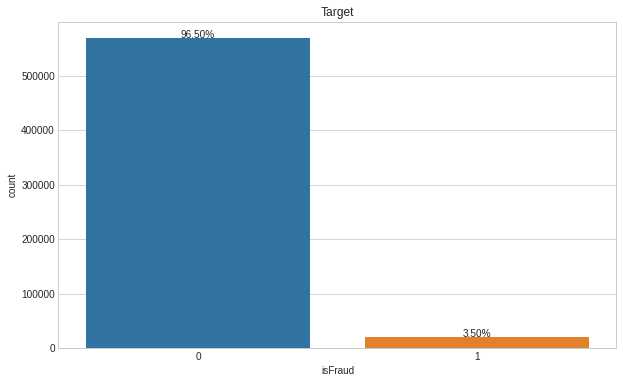

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,6))
sns.countplot(df_train['isFraud'])
axes.title.set_text('Target')
total = float(df_train['isFraud'].shape[0])  
for p in axes.patches:
    height = p.get_height()
    axes.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 
plt.show()


As expected our data is highly imbalanced. About 96.5% of the transactions are not fraud. Only about 3.5% is fraud transactions

## [2.2] TransactionDT


This is actually a timedelta from a given reference datetime (not an actual timestamp). For example: 86400 can be 86400 seconds from a perticulat time, for eg: from 2/12/2010 12:05:09 pm. 

Here we have to check the data obtained in train and test is continous with time. This is important for train-test split. That means training data should be from a earlier period and test data should be from a later period of time.

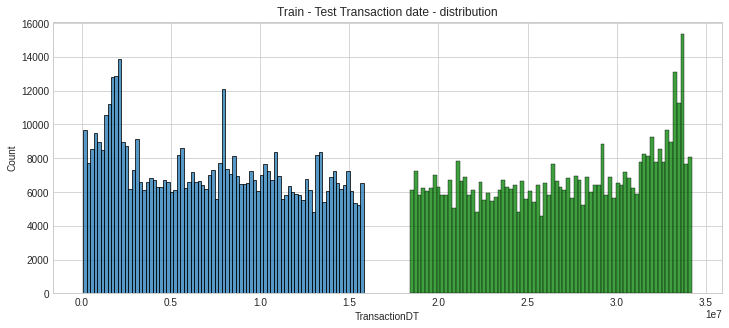

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,5))
sns.histplot(df_train['TransactionDT'])
sns.histplot(df_test['TransactionDT'],color='g')
axes.title.set_text('Train - Test Transaction date - distribution')
plt.show()

* There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact train validation split or cross validation techniques should be used.
* Another observation is that there are certain days in which number of transactions is more than 10000

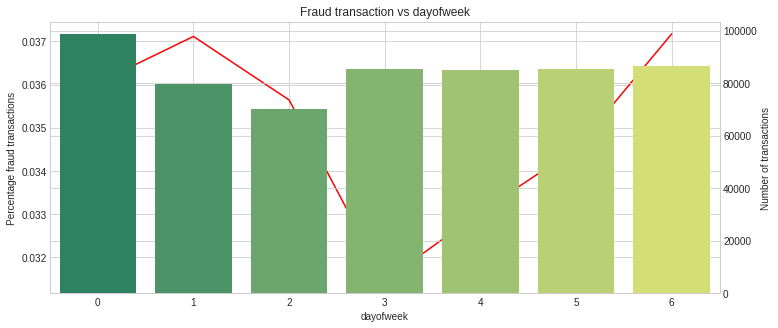

In [ ]:
df_train['dayofweek'] = (df_train['TransactionDT']//(60*60*24)-1)%7
tmp = df_train[['isFraud','dayofweek']].groupby(by=['dayofweek']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID','dayofweek']].groupby(by=['dayofweek']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['dayofweek'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['dayofweek'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['dayofweek'],y=tmp['Number of transactions'],palette='summer')
axes.set_title('Fraud transaction vs dayofweek')
plt.show()


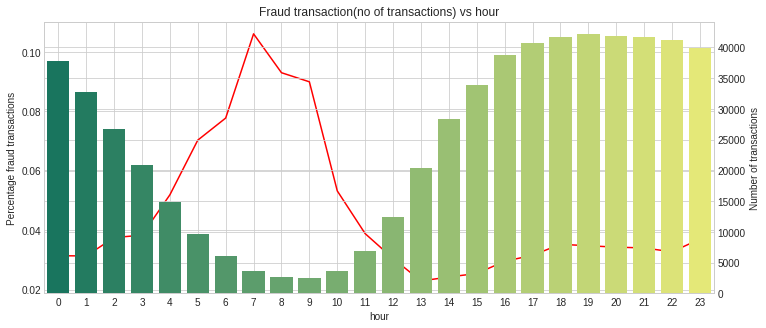

In [ ]:
df_train['hour'] = (df_train['TransactionDT']//(60*60))%24
tmp = df_train[['isFraud','hour']].groupby(by=['hour']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID','hour']].groupby(by=['hour']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['hour'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['hour'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['hour'],y=tmp['Number of transactions'],palette='summer')
axes.set_title('Fraud transaction(no of transactions) vs hour')
plt.show()




We can create 4 categorical values from these 

* high(6,7,8,9) : From 6am to 9am
* medium(3,4,5,10,11)
* low(11,12,16-0,1-2)
* very low(13,14,15,)

## [2.3] TransactionAmt

* This is the amount associated with each transaction. We dont have any missing values in any of the transaction.
Let us see tha average amount involved in transactions per hour and its fraudulen rate.

In [ ]:
df_train['TransactionAmt'].isnull().sum()

0

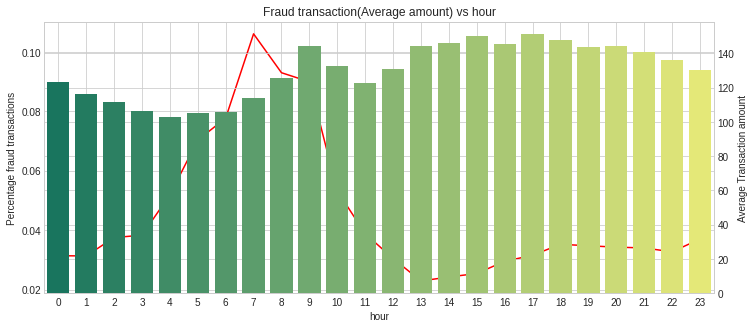

In [ ]:
df_train['hour'] = (df_train['TransactionDT']//(60*60))%24
tmp = df_train[['isFraud','hour']].groupby(by=['hour']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_amount = df_train[['TransactionAmt','hour']].groupby(by=['hour']).mean().reset_index() \
            .rename(columns={'TransactionAmt':'Average Transaction amount'})
tmp = tmp.merge(tmp_amount,on=['hour'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['hour'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['hour'],y=tmp['Average Transaction amount'],palette='summer')
axes.set_title('Fraud transaction(Average amount) vs hour')
plt.show()




### checking outliers 

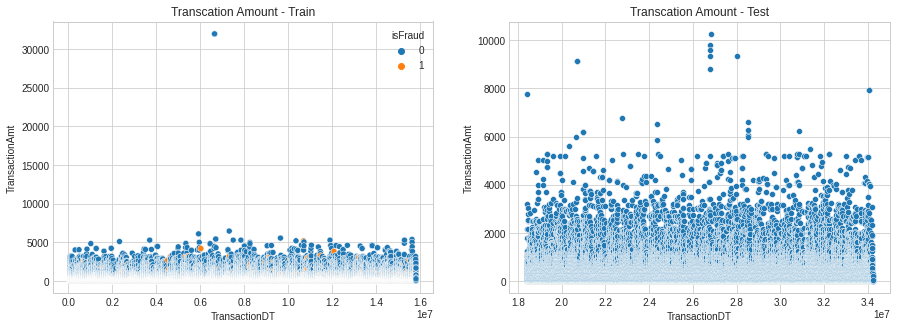

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(y=df_train['TransactionAmt'],x=df_train['TransactionDT'],hue=df_train['isFraud'],ax=axes[0])
axes[0].title.set_text('Transcation Amount - Train')

sns.scatterplot(y=df_test['TransactionAmt'],x=df_test['TransactionDT'],ax=axes[1])
axes[1].title.set_text('Transcation Amount - Test')

plt.show()

We can see that there is one point in train data where amount > 30000. Its better we remove the outlier, since it can affect our models(espetially distane based algorithms like logistic regression, knn etc) in prediction.

Also Outliers like this can cause an overfitting problem. For instance, in tree-based models can put these outliers in leaf nodes, which are noise and not part of a general pattern. Therefore, I decided to remove the values larger than 30,000 in the training set.

In [ ]:
# df_train = df_train[df_train['TransactionAmt'] < 30000]
# df_train.shape

### distribution

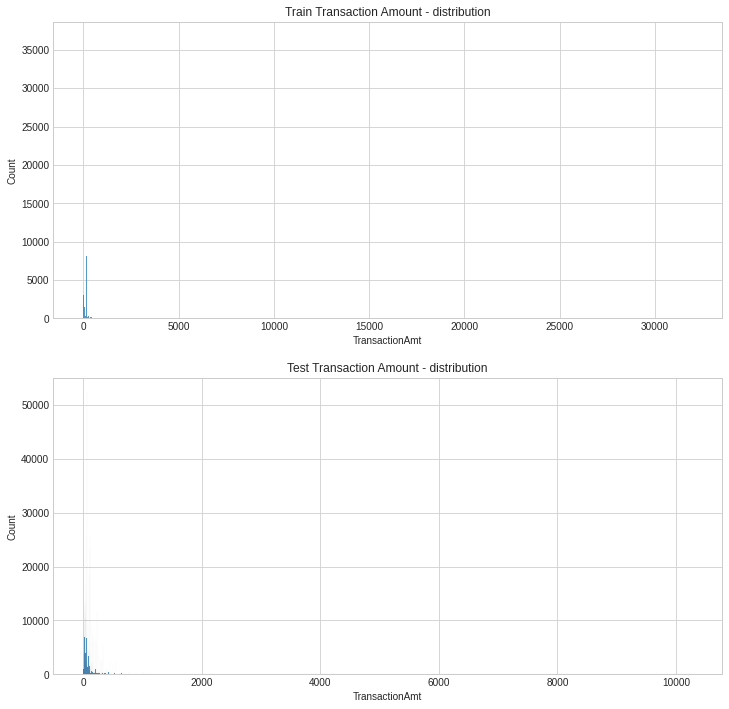

In train data Minimum transaction amount is 0.251 and maximum amount  is 31937.391
In test data Minimum transaction amount is 0.018000000000000002 and maximum amount  is 10270.0


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
sns.histplot(df_train['TransactionAmt'],ax=axes[0])
sns.histplot(df_test['TransactionAmt'],ax=axes[1])
axes[0].title.set_text('Train Transaction Amount - distribution')
axes[1].title.set_text('Test Transaction Amount - distribution')
plt.show()

print(f'In train data Minimum transaction amount is {df_train["TransactionAmt"].min()} and maximum amount  is {df_train["TransactionAmt"].max()}')
print(f'In test data Minimum transaction amount is {df_test["TransactionAmt"].min()} and maximum amount  is {df_test["TransactionAmt"].max()}')

I have done a log transform - otherwise the few, very large transactions skew the distribution. Beacuse majority of transactions are on smaller amount.

### TransactionAmt vs Fraud

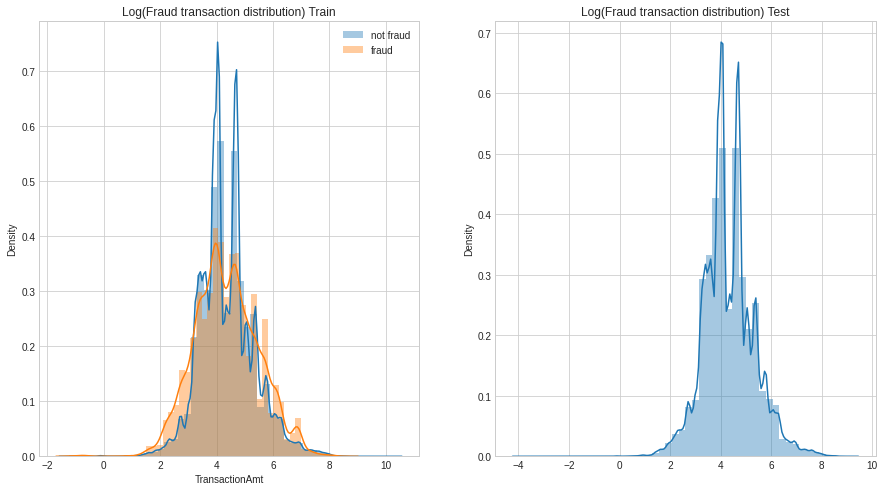

In [ ]:
test_amt = np.log(df_test[['TransactionAmt']])

dff_fraud = df_train[df_train['isFraud'] == 1]
dff_notfraud = df_train[df_train['isFraud'] == 0]

dff_fraud['TransactionAmt'] = np.log(dff_fraud['TransactionAmt'])
dff_notfraud['TransactionAmt'] = np.log(dff_notfraud['TransactionAmt'])


fig,axes = plt.subplots(1,2,figsize=(15,8))
sns.distplot(dff_notfraud['TransactionAmt'],ax=axes[0],label='not fraud')
sns.distplot(dff_fraud['TransactionAmt'],ax=axes[0],label='fraud')
axes[0].title.set_text('Log(Fraud transaction distribution) Train')
axes[0].legend()

sns.distplot(test_amt,ax=axes[1])
axes[1].title.set_text('Log(Fraud transaction distribution) Test')
plt.show()

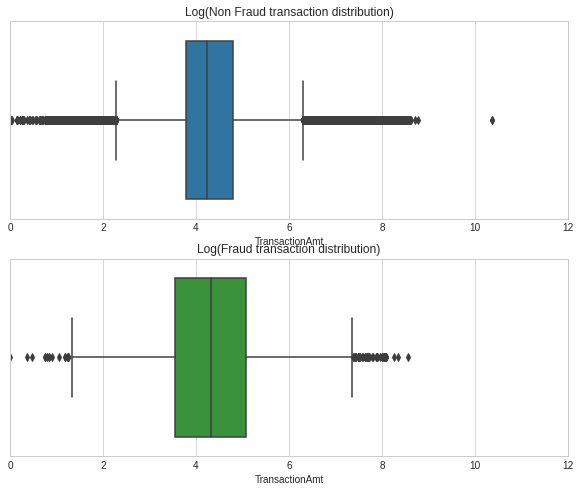

Mean transaction amt for fraud is 4.3506 ie, 77.5264 dollars
Mean transaction amt for non-fraud is 4.3643 ie, 78.5978 dollars
Median transaction amt for fraud is 4.3175  ie, 75.0000 dollars
Median transaction amt for non-fraud is 4.2268  ie, 68.5000 dollars


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
sns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])
axes[0].title.set_text('Log(Non Fraud transaction distribution)')
axes[0].set(xlim=(0, 12))
sns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])
axes[1].title.set_text('Log(Fraud transaction distribution)')
axes[1].set(xlim=(0, 12))
plt.show()

print('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))
print('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))

print('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))
print('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp(dff_notfraud['TransactionAmt'].median())))

* Fraudulant transactions have slightly higher median.
* Also in Fradulant transactions we have a better normal distribution which is wide at bell curve. It indicates more transactions are present at a particlar intreval which are fraudulant.
* It seems that the transactions with 'LogTransactionAmt' larger than 5.5 (244 dollars) and smaller than 3.3 (27 dollars) have a higher frequency and probability density of being fraudulent. On the other hand, the ones with 'LogTransactionAmt' from 3.3 to 5.5 have a higher chance of being legit.

## [2.4] ProductCD

This is the product code associated with each transaction

In [ ]:
df_train['ProductCD'].isnull().sum()

0

In [ ]:
df_train['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

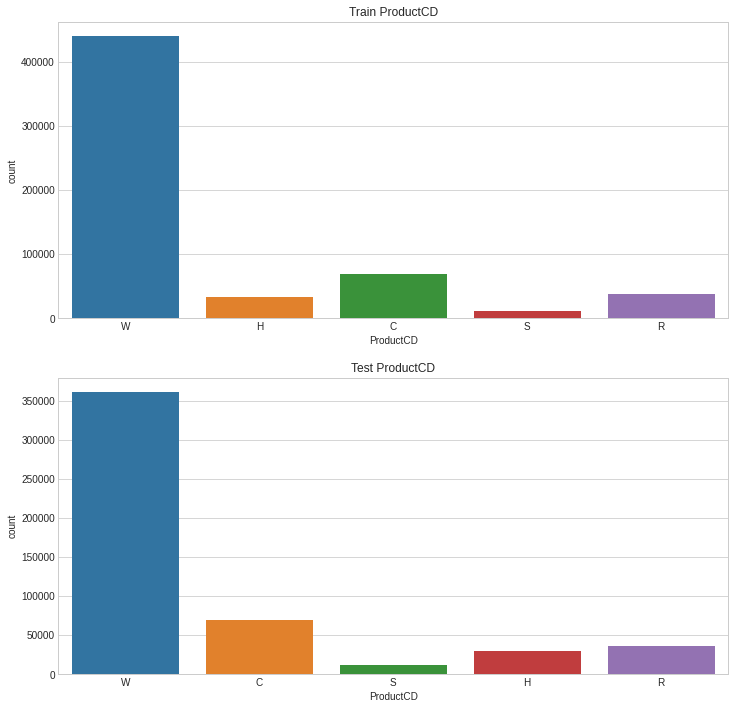

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
sns.countplot(df_train['ProductCD'],ax=axes[0])
sns.countplot(df_test['ProductCD'],ax=axes[1])
axes[0].title.set_text('Train ProductCD')
axes[1].title.set_text('Test ProductCD')
plt.show()

In [ ]:
# idea from https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda
def hor_plot(feat,df=df_train,label_rotation=False,shape=(12,8)):
    
    val_cnts = df[feat].value_counts()
    df1 = pd.DataFrame({feat: val_cnts.index,'Number of units': val_cnts.values})
    # Calculate the percentage of target=1 per category value.For that what we did is we took the mean value of TARGET
    percent = df[[feat, 'isFraud']].groupby([feat],as_index=False).mean()
    percent.sort_values(by='isFraud', ascending=False, inplace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=shape)
    s = sns.barplot(ax=ax1, x = feat, y="Number of units",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feat, y='isFraud', order=percent[feat], data=percent)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    plt.ylabel('Percent of Fraud transactions [Target with value 1]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();


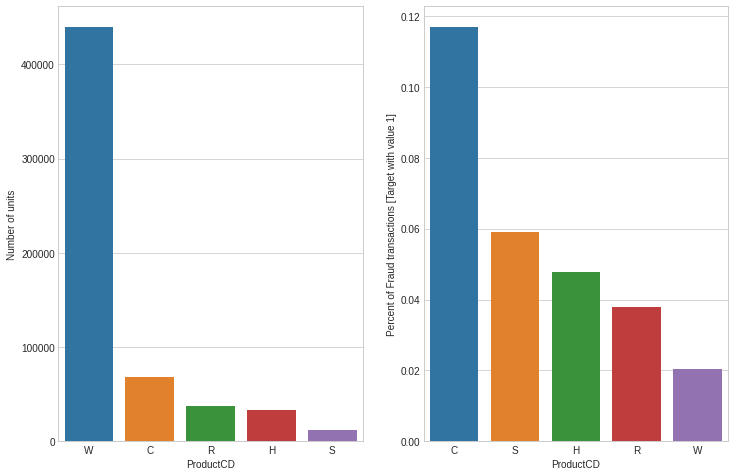

In [ ]:
hor_plot(df=df_train,feat='ProductCD')

* We can see that Product W is present most among all transactions. In fraud transactions also the count of product W is more. But only about 2% of all Product W transaction is fraud.
* About 11.5% of all ProductC are fraudulant trnasactions
* Also about 6% of all ProductS transactions are fraud.

## [2.5] Card 1 - 6

It has payment card related information like card type, country etc. It is given that these features are categorical. 

In [ ]:
cards = [col for col in df_train.columns if 'card' in col]
df_train[cards].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

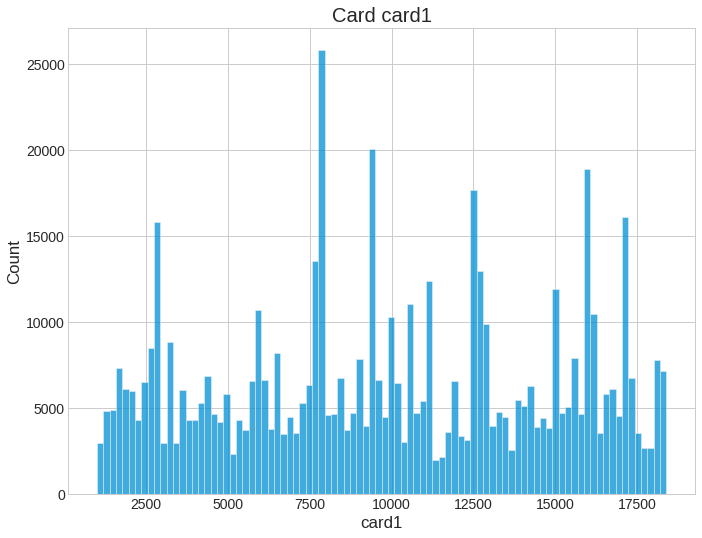

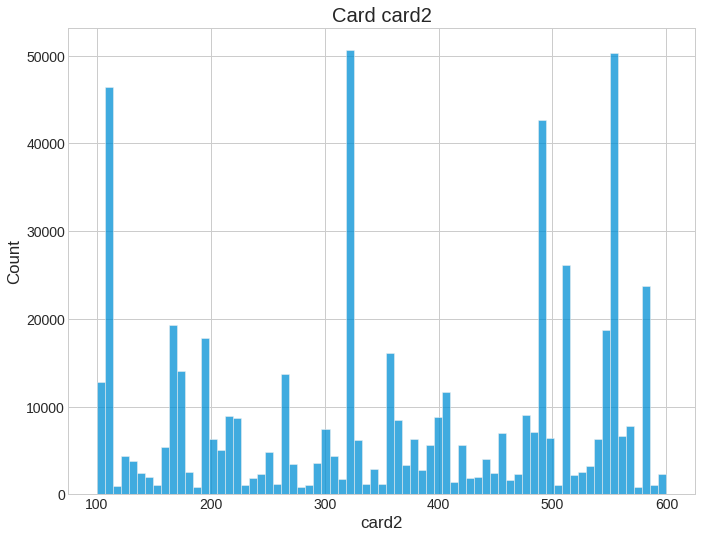

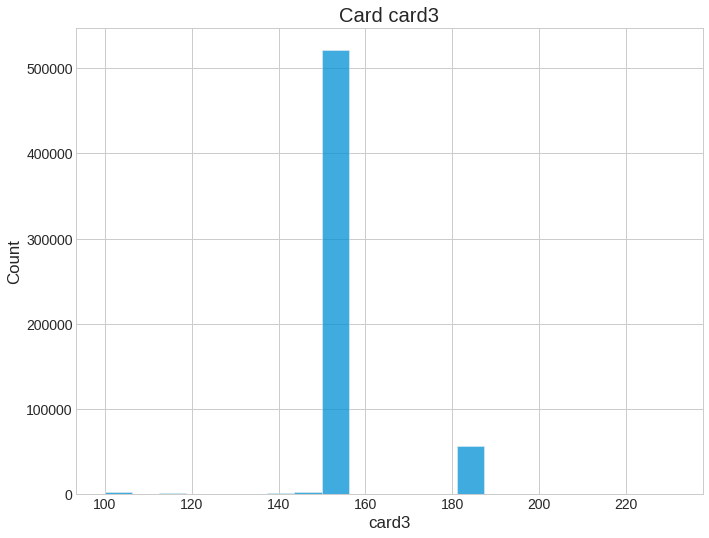

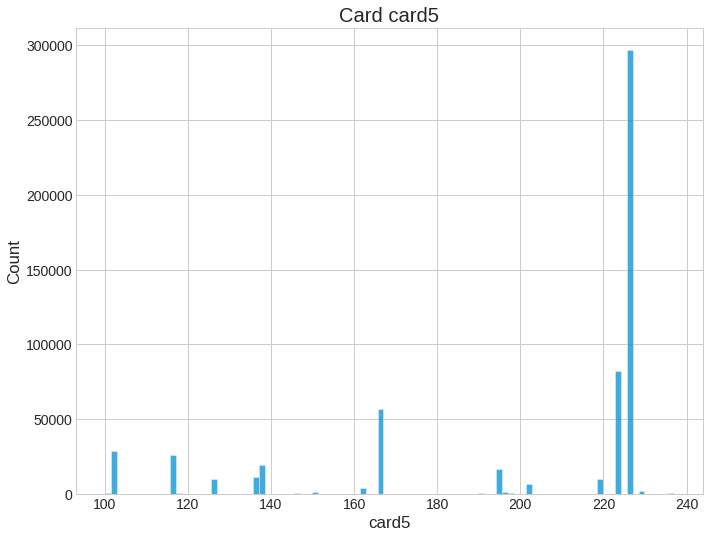

In [ ]:
for c in cards:
    if df_train[c].dtypes in ['int64','float64']:
        fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,8))
        sns.histplot(df_train[c])
        axes.title.set_text(f'Card {c}')
        plt.show()
    

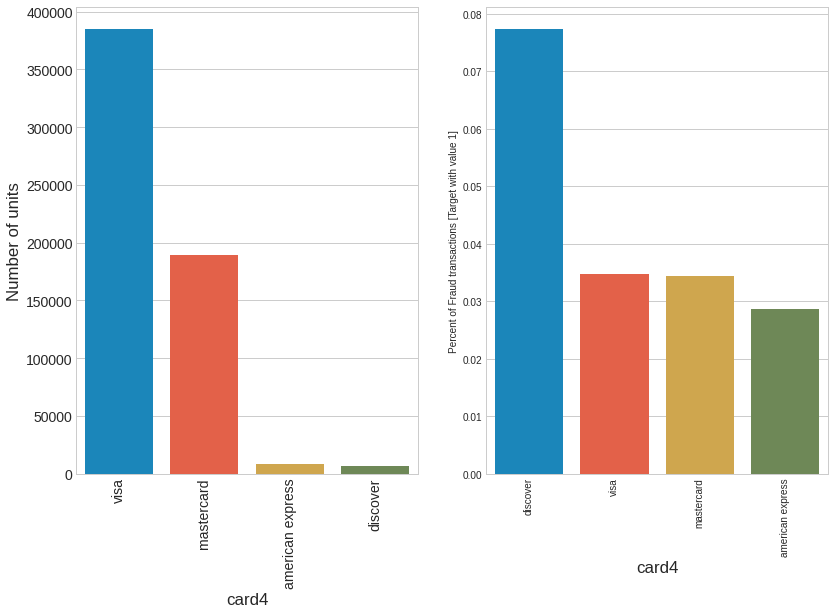

In [ ]:
hor_plot('card4',label_rotation=True)

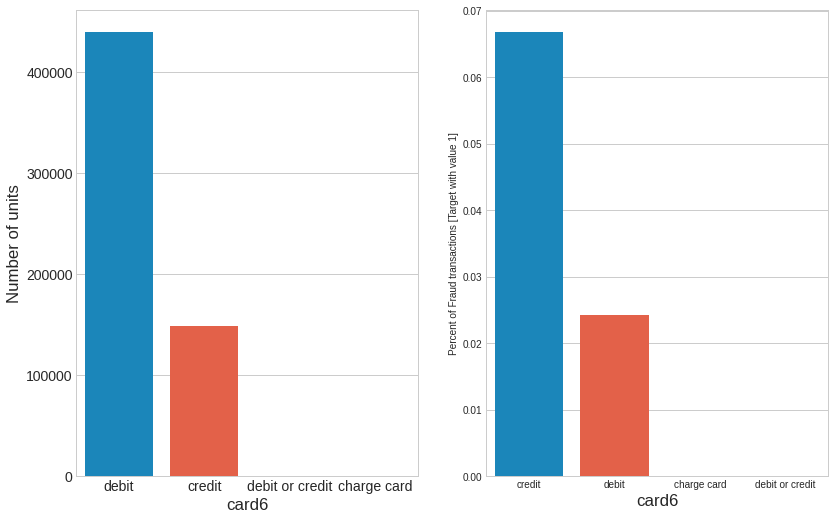

In [ ]:
hor_plot('card6')

In [ ]:
cards = ['card1','card2','card3','card4','card5','card6','isFraud']
df_train[cards].corr()

card1     card2     card3     card5   isFraud
card1    1.000000  0.004960  0.002965 -0.093633 -0.013640
card2    0.004960  1.000000  0.023816  0.030486  0.003388
card3    0.002965  0.023816  1.000000 -0.158383  0.154151
card5   -0.093633  0.030486 -0.158383  1.000000 -0.033580
isFraud -0.013640  0.003388  0.154151 -0.033580  1.000000

* We can see that for card1 and card2 we have lot of categorical values.It behaves like numeric features.
* We can see that among credit card there is more chance to have fraud transactions. It is about 6.5% of all transactions.
* Also among card4 discover card have a highest fraudelent cases of about 7.6%
* card3 has low coorelation with other card features.

## [2.6] P_email domain and R_email domain

Email domain of purchaser and email domain of recipiant

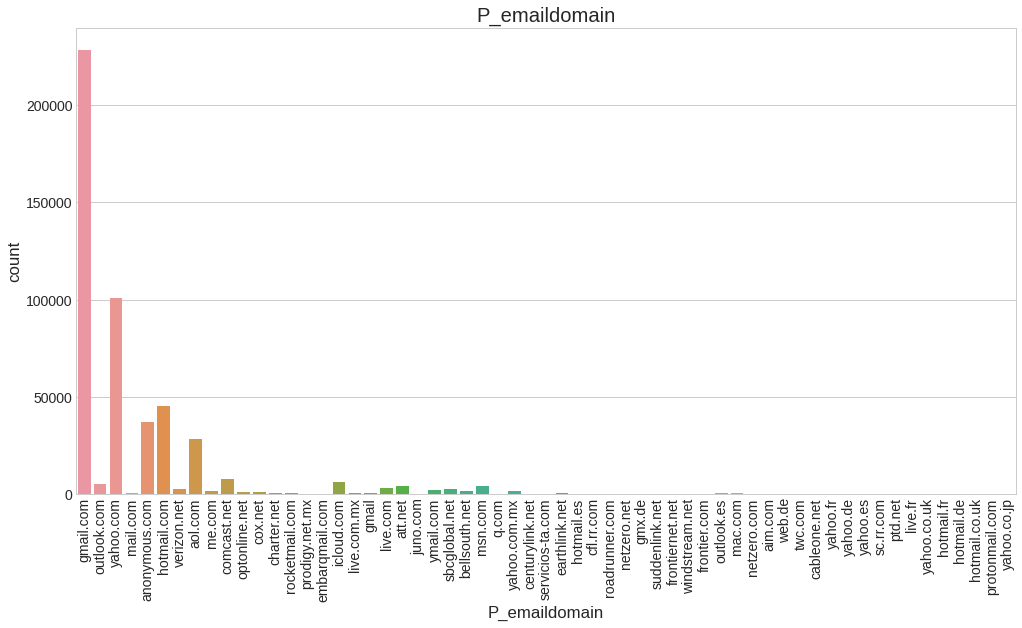

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
sns.countplot(df_train_transaction['P_emaildomain'])
axes.title.set_text('P_emaildomain')
axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

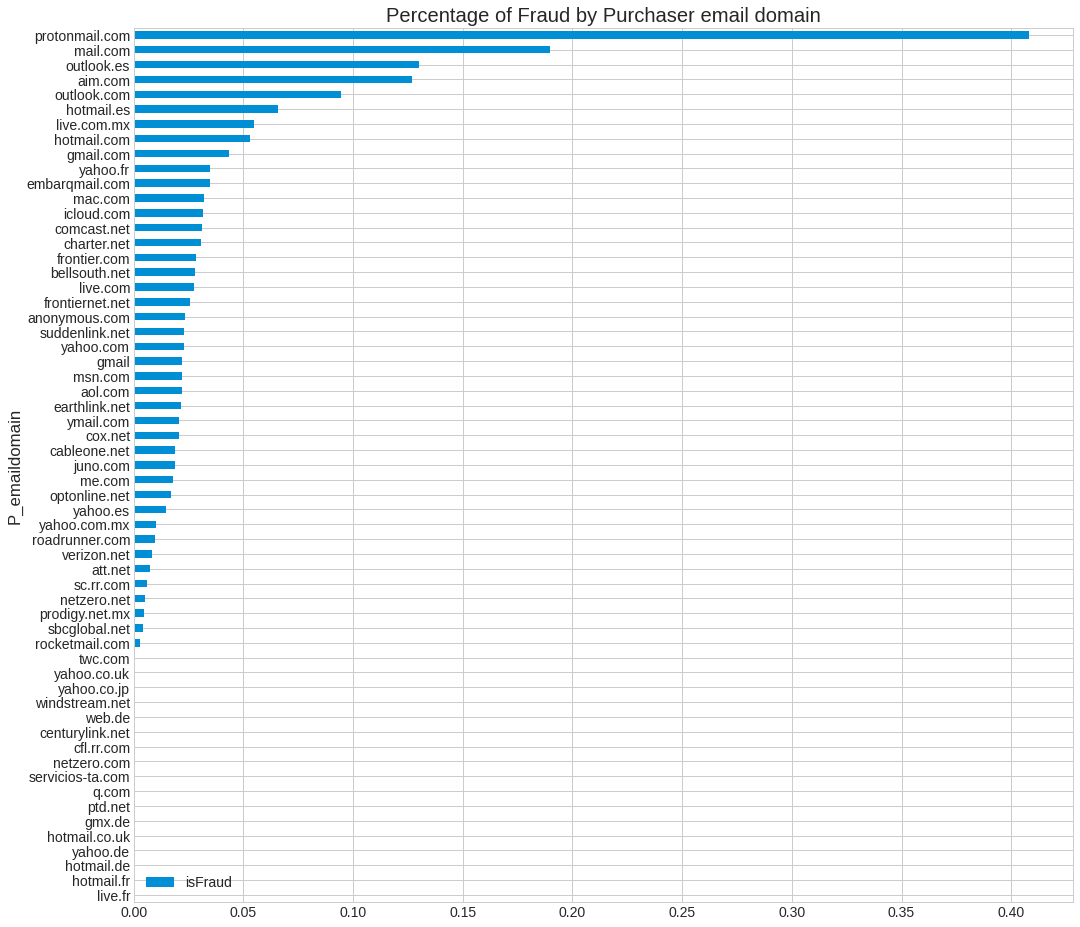

In [ ]:
df_train_transaction[['P_emaildomain','isFraud']].groupby(by=['P_emaildomain']).mean() \
        .sort_values(by=['isFraud']).plot(kind='barh',
        figsize=(15, 15),
         title='Percentage of Fraud by Purchaser email domain')
plt.show()


* In purchaser email domains most mails are from gmail.com
* Among those More fraud transaction comes from domain protonmail.com which is more than 40%.

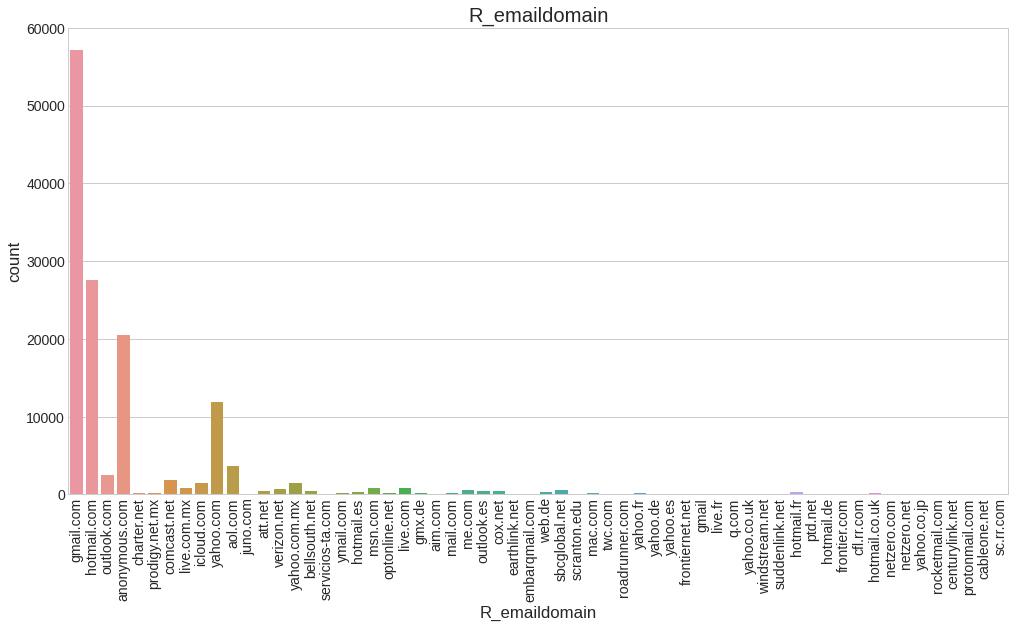

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
sns.countplot(df_train_transaction['R_emaildomain'])
axes.title.set_text('R_emaildomain')
axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

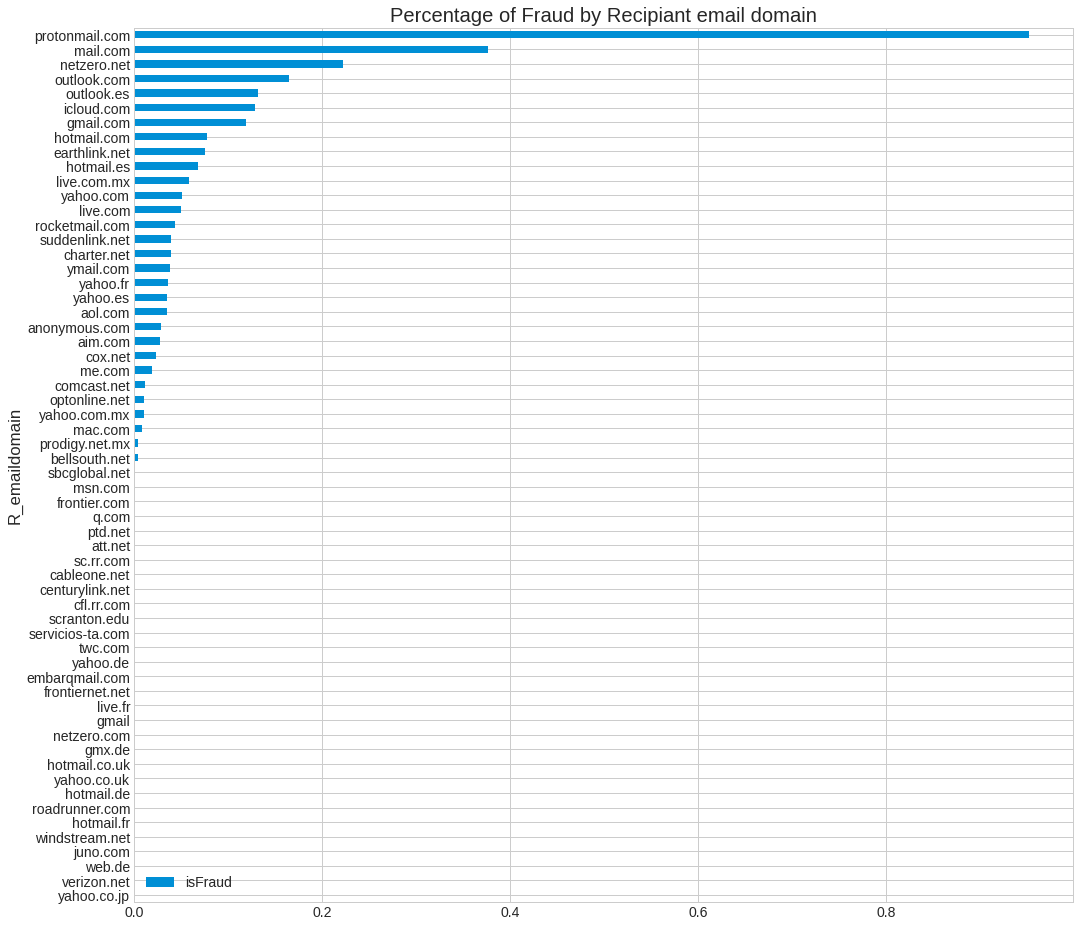

In [ ]:
df_train_transaction[['R_emaildomain','isFraud']].groupby(by=['R_emaildomain']).mean() \
        .sort_values(by=['isFraud']).plot(kind='barh',
        figsize=(15, 15),
         title='Percentage of Fraud by Recipiant email domain')
plt.show()

* In purchaser email domains most mails are from gmail.com
* Among those More fraud transaction comes from domain protonmail.com which is more than 90% which is a serious issue.

## [2.7] Adddr1 and Addr2

This is some categorical data giving address information 

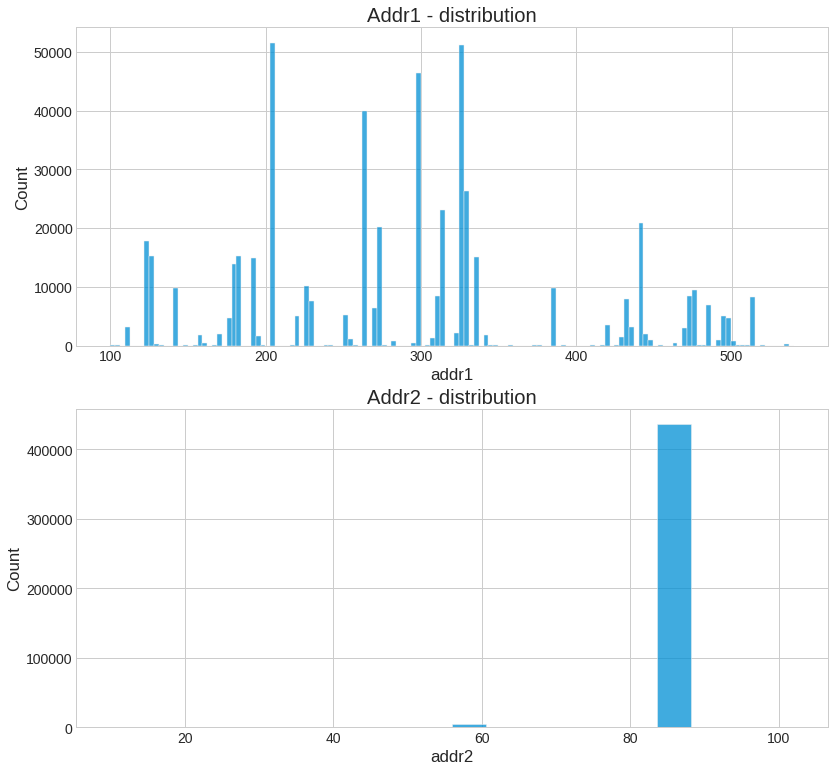

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
sns.histplot(df_train_transaction['addr1'],ax=axes[0])
sns.histplot(df_test_transaction['addr2'],ax=axes[1])
axes[0].title.set_text('Addr1 - distribution')
axes[1].title.set_text('Addr2 - distribution')
plt.show()

## [2.7] Dist1 and Dist2
This might indicate the distance between transaction location and card owner address.This is just my assumption.

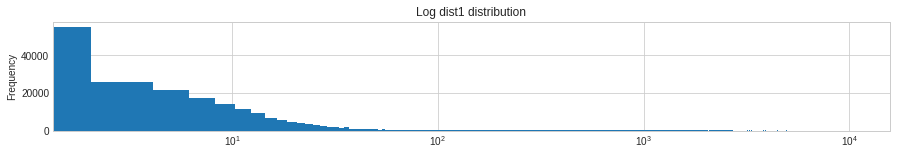

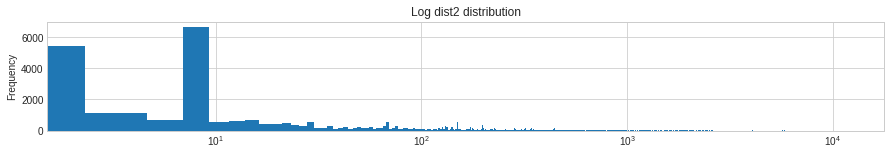

In [ ]:
df_train['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='Log dist1 distribution',
                                color=colors[0],
                                logx=True)
plt.show()
df_train['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='Log dist2 distribution',
                                color=colors[0],
                                logx=True)
plt.show()

* It is also important to note that about 93% of data is missing in dist2

## [2.8] C1-C14

In [ ]:
c_cols = [c for c in df_train if c[0] == 'C']
df_train[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

In [ ]:
# Sample 500 fraud and 500 non-fraud examples to plot
sample_df = pd.concat([df_train.loc[df_train['isFraud'] == 0].sample(500),
                       df_train.loc[df_train['isFraud'] == 1].sample(500)])


<Figure size 1440x1440 with 0 Axes>

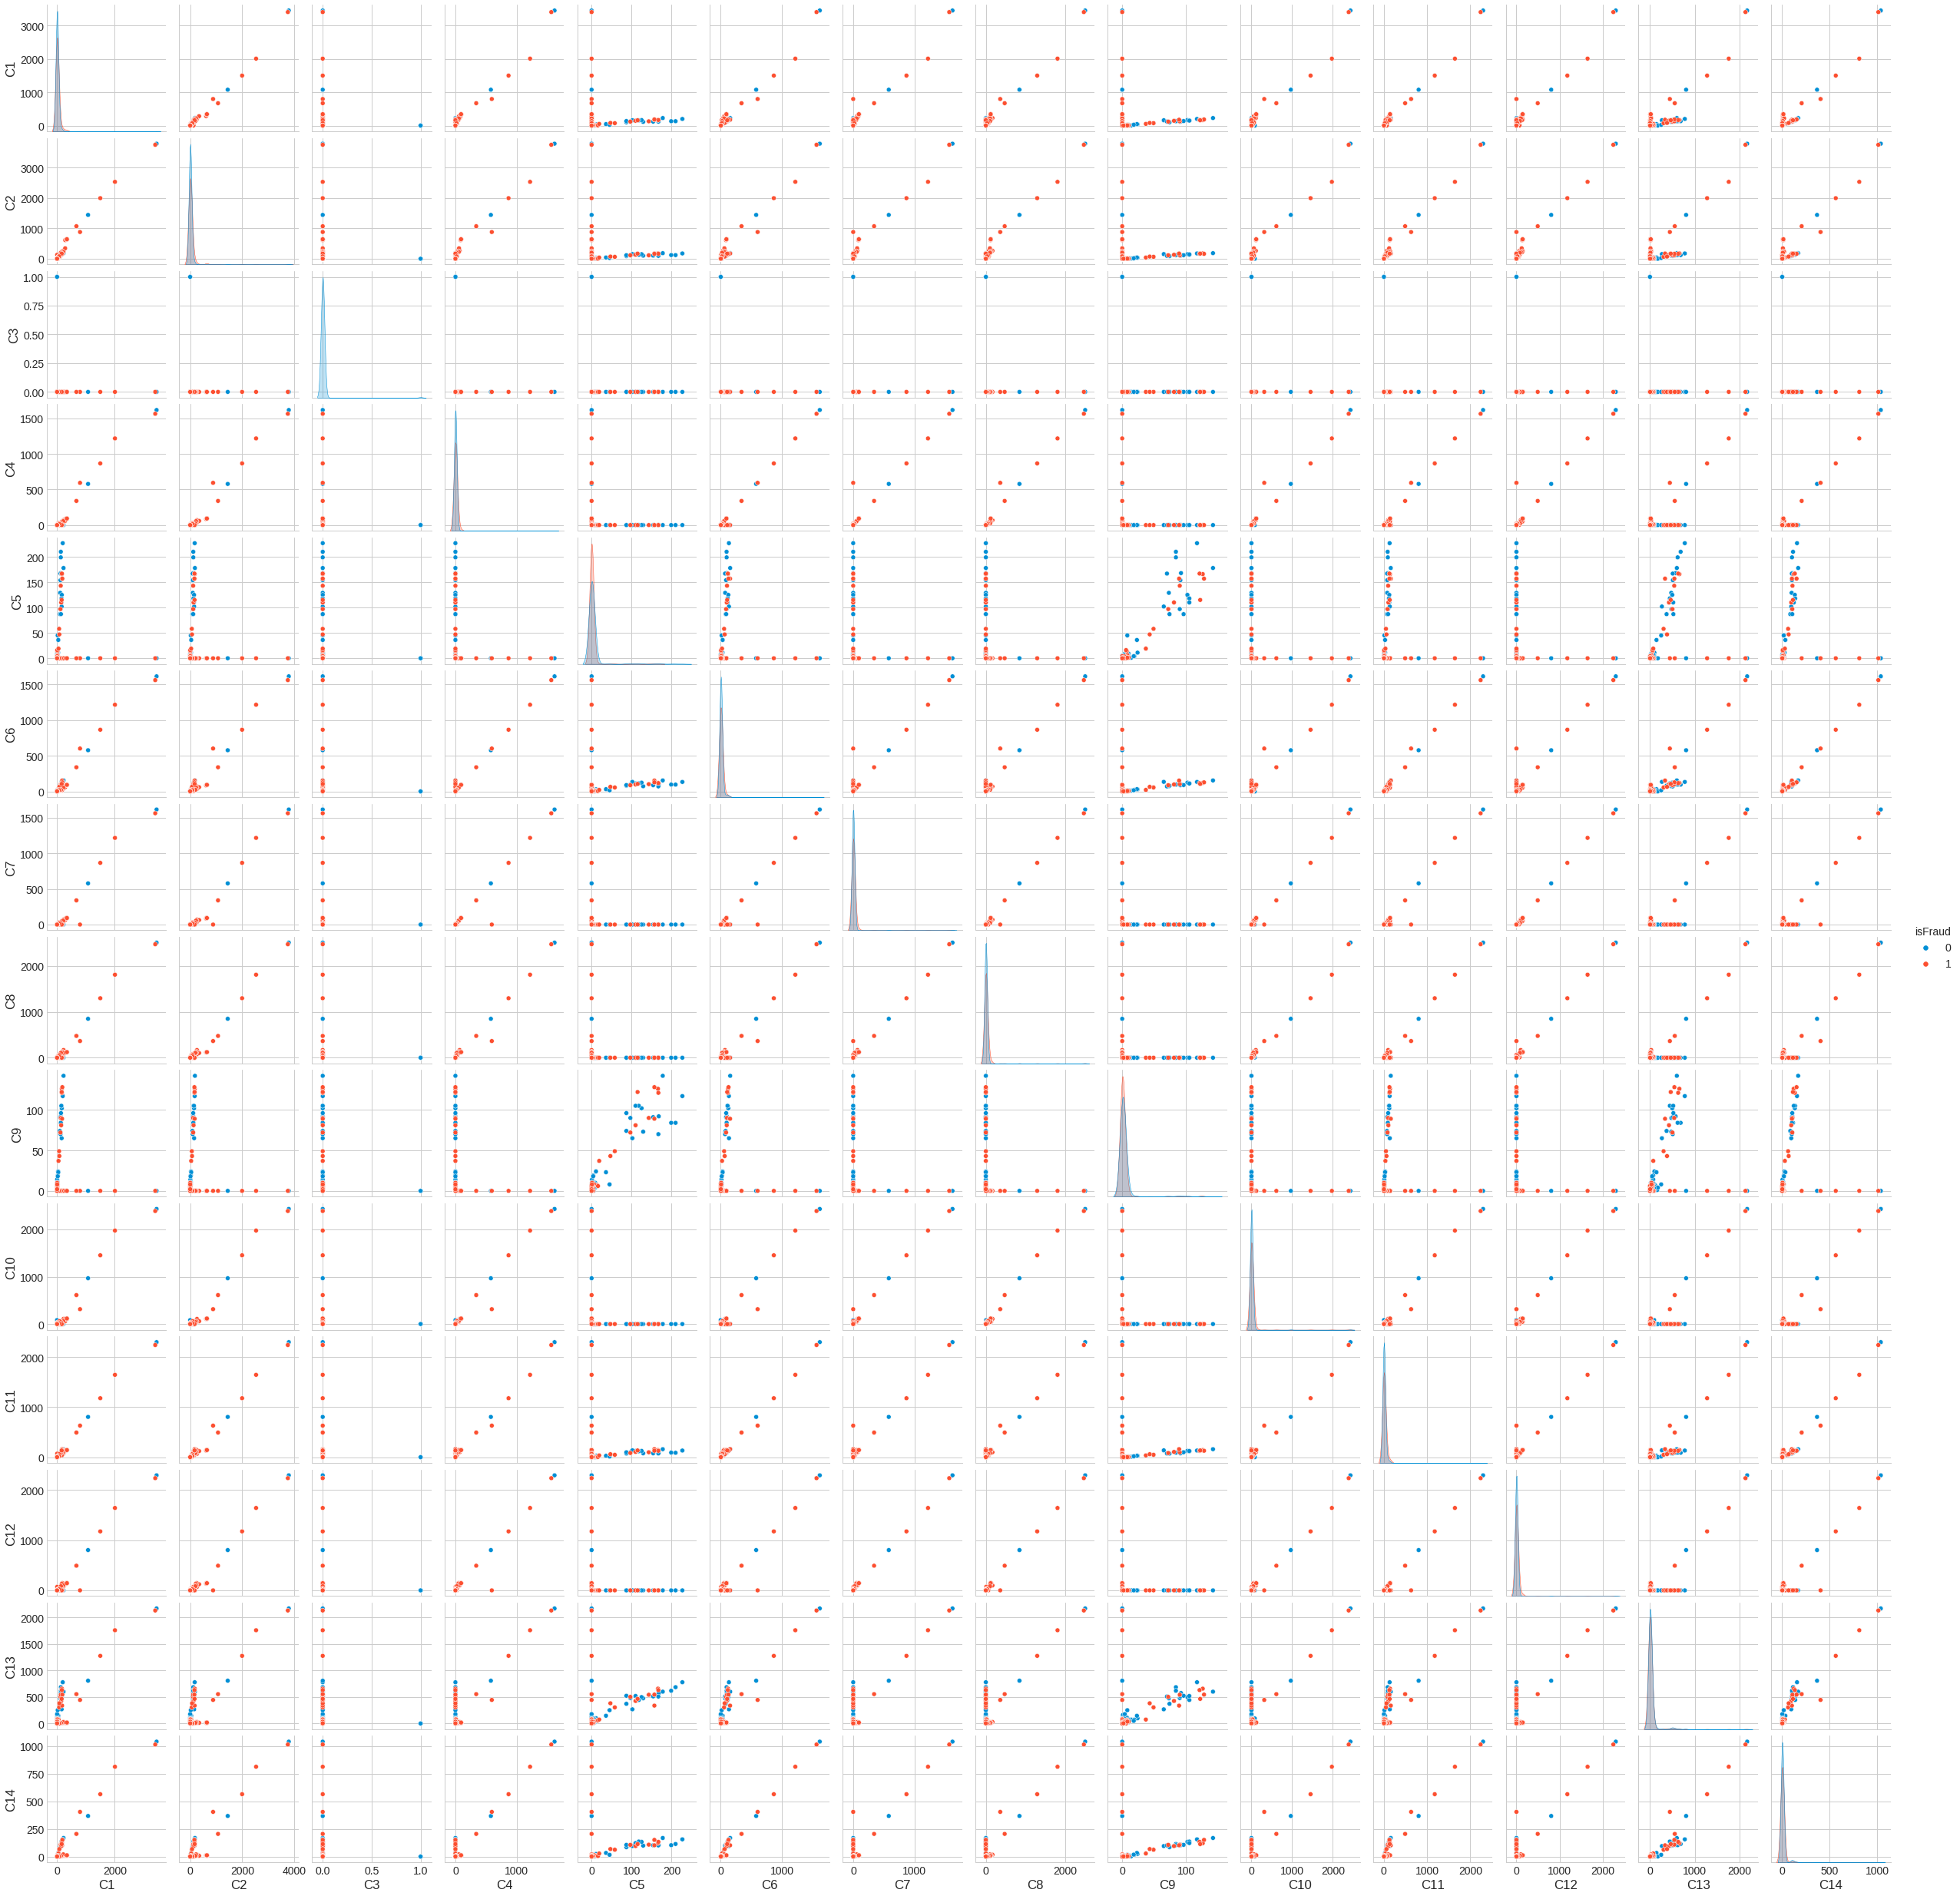

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(sample_df, 
             hue='isFraud',
            vars=c_cols,height=5)
plt.show()

* We can see that linearity as well as non linearity exist between features

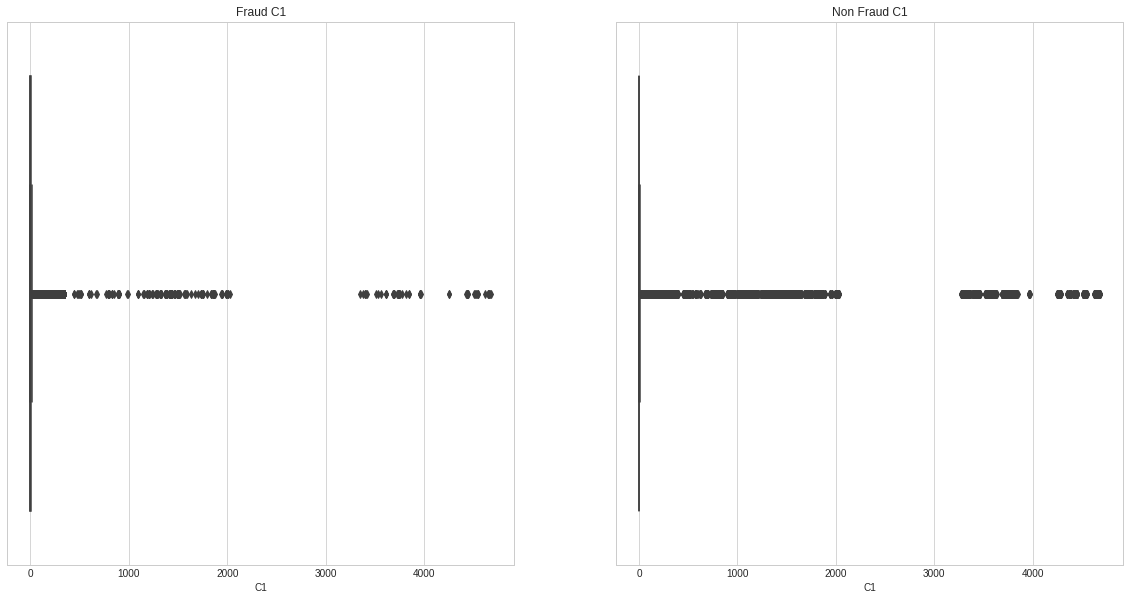

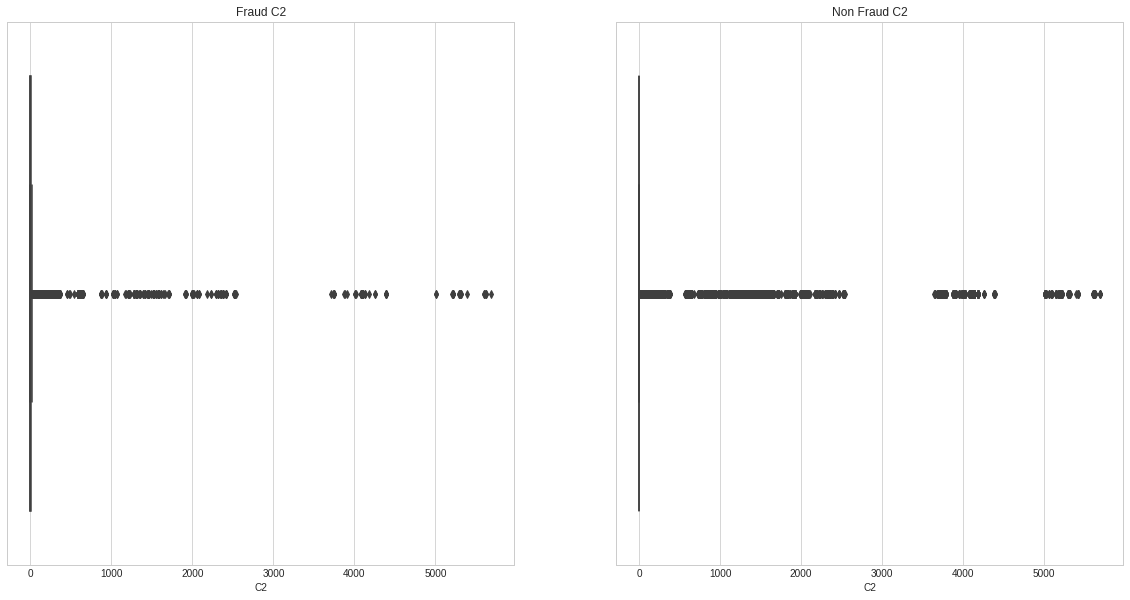

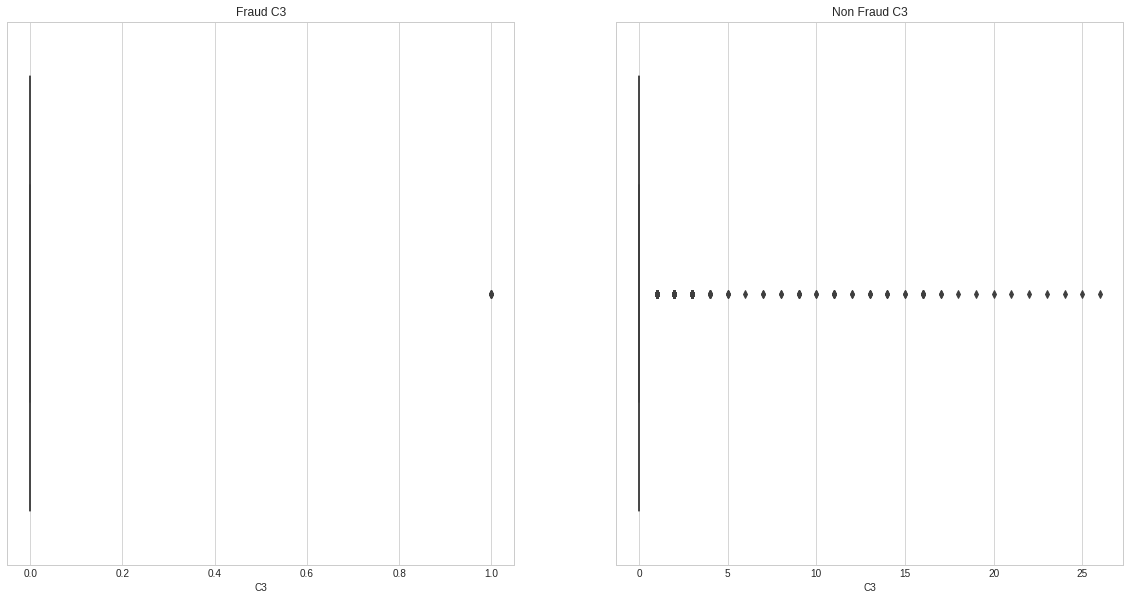

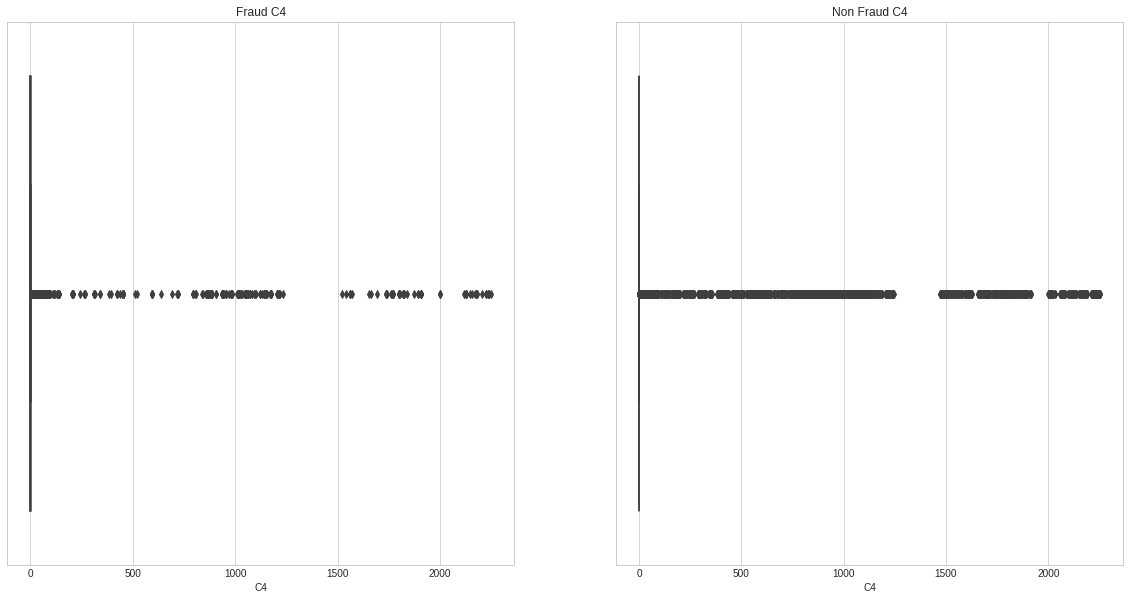

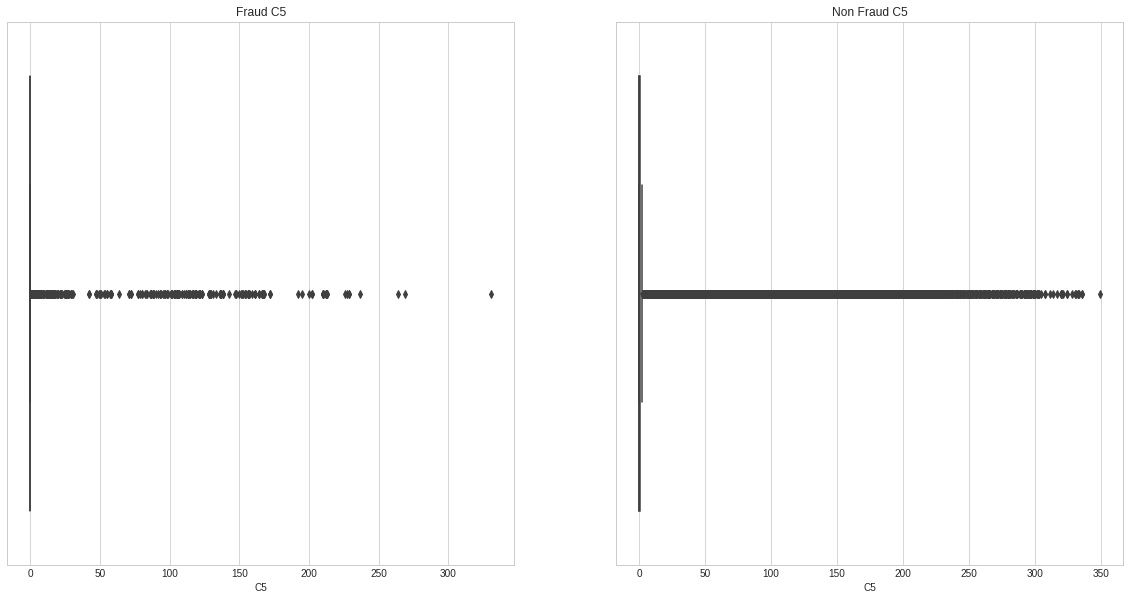

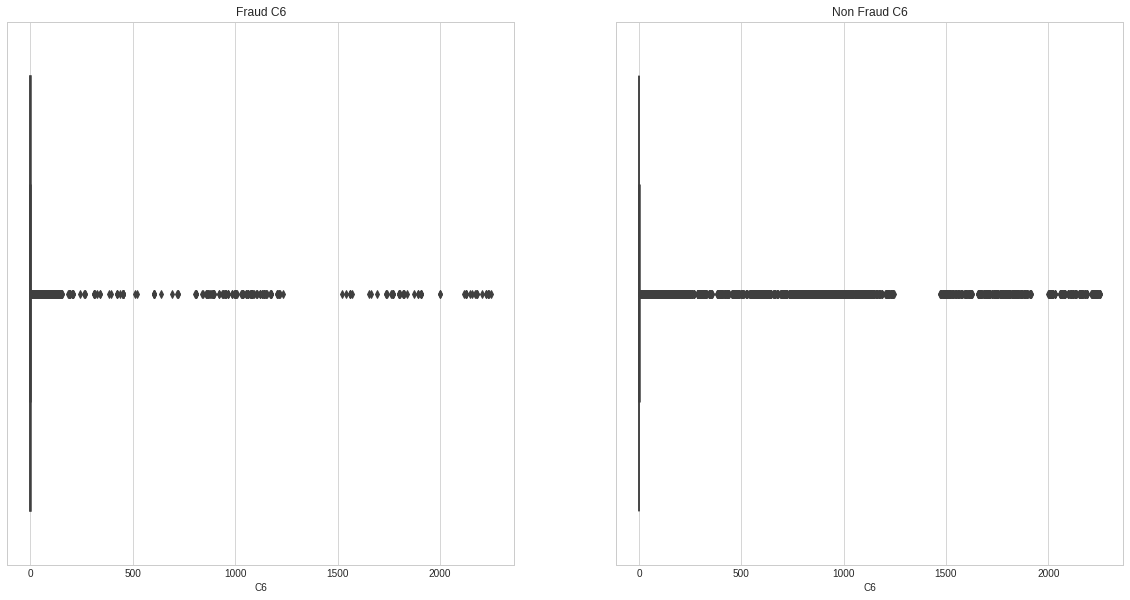

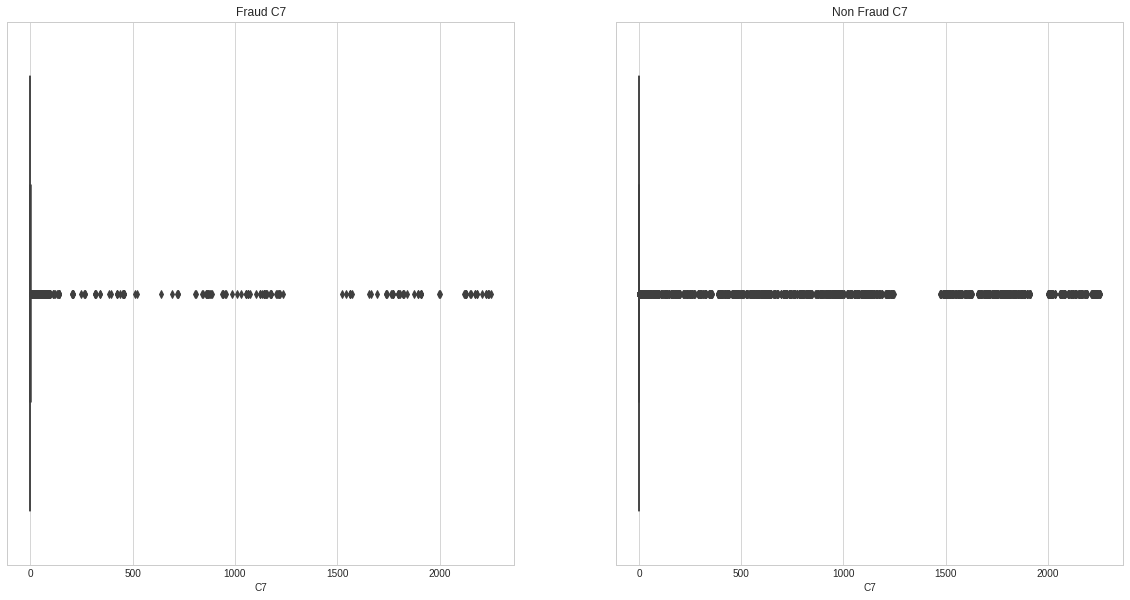

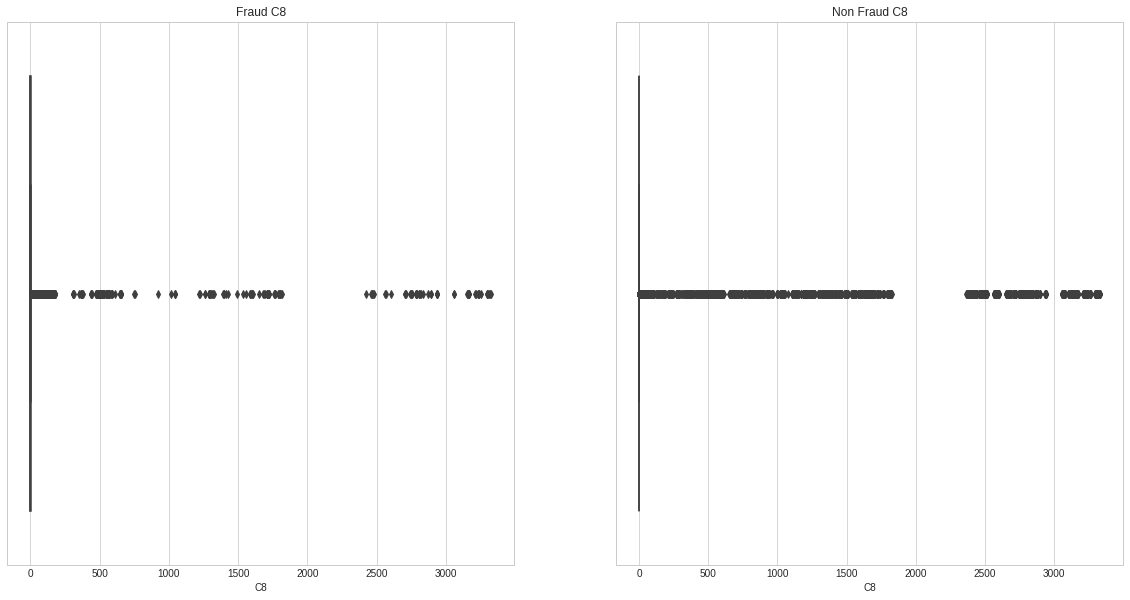

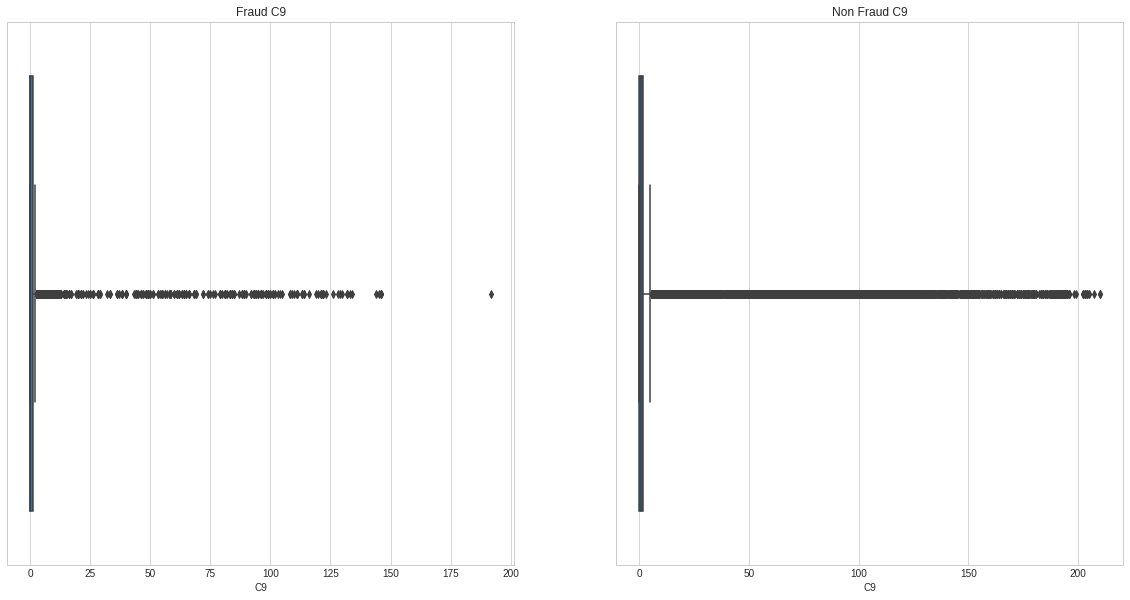

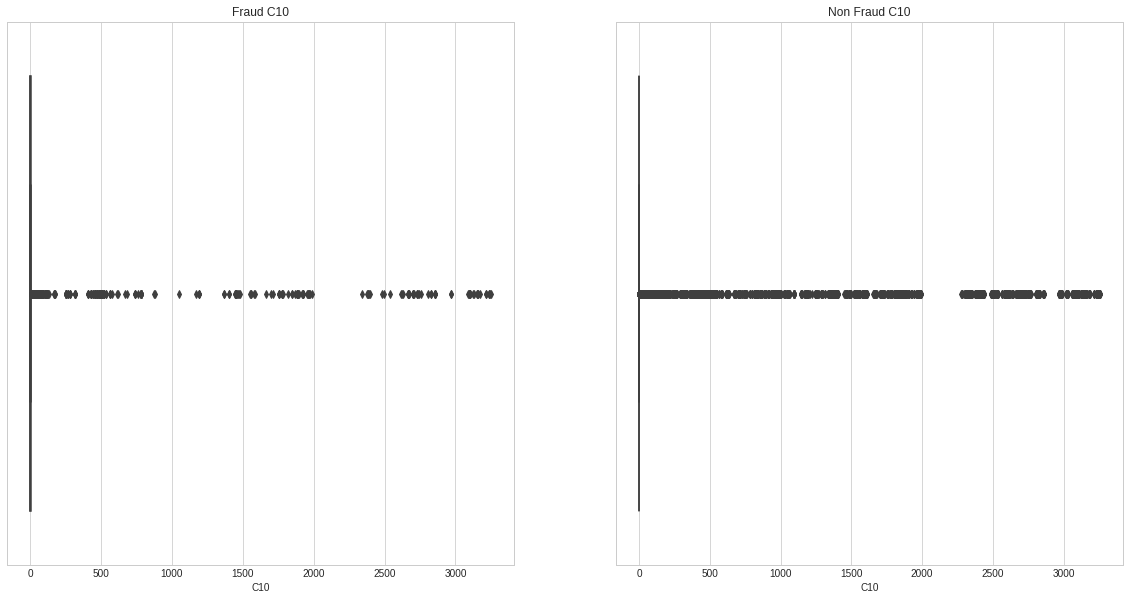

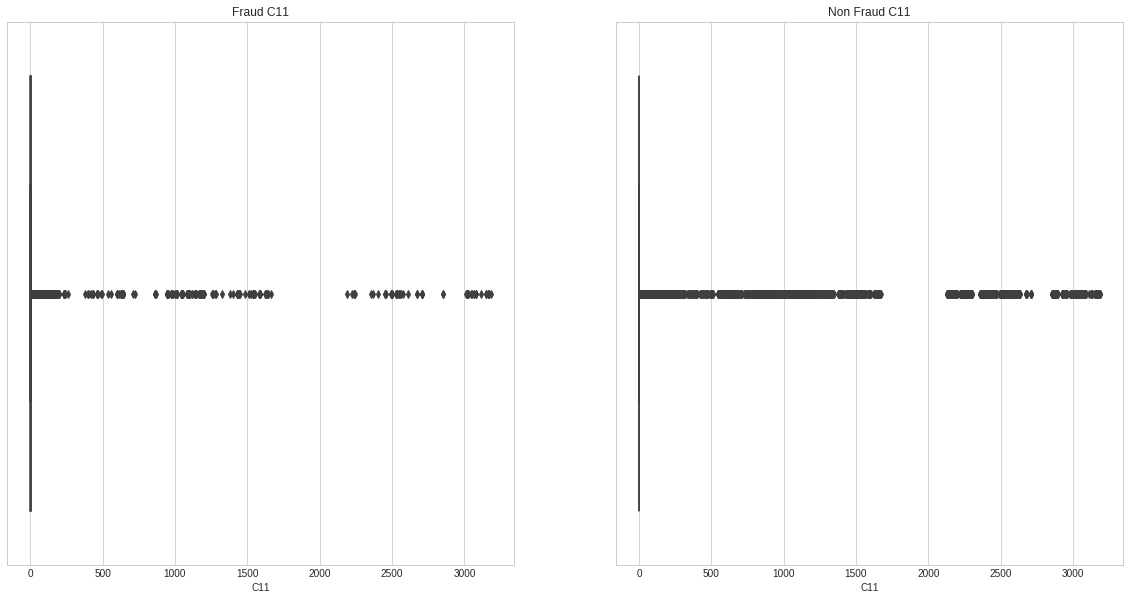

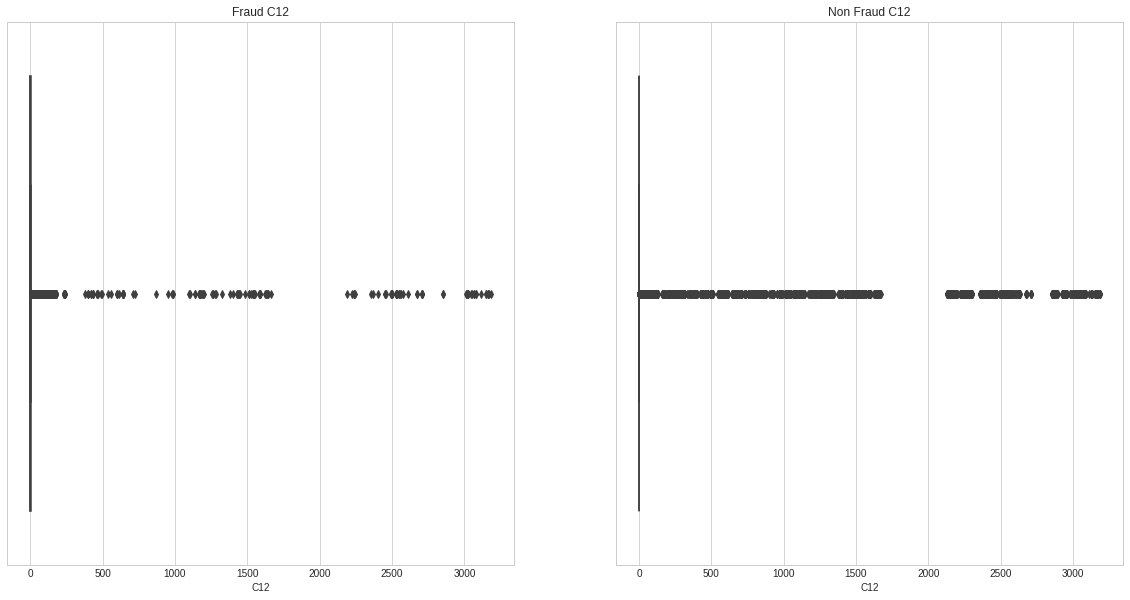

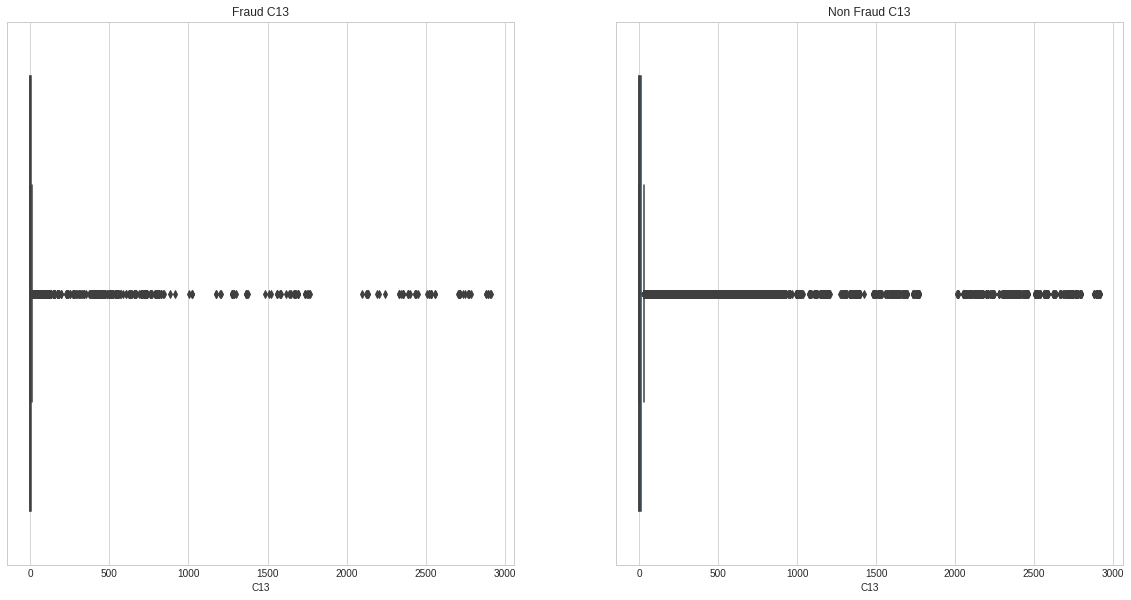

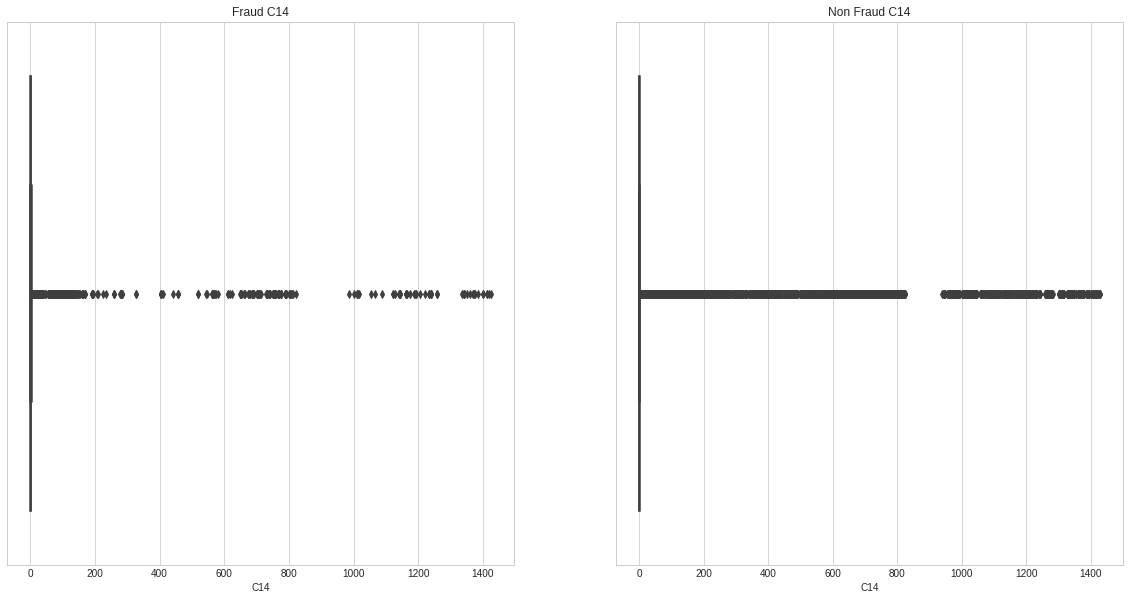

In [ ]:
for col in c_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    fraud_df = df_train[df_train['isFraud'] == 1]
    nonfraud_df = df_train[df_train['isFraud'] == 0]
    sns.boxplot(fraud_df[col],ax=axes[0])
    sns.boxplot(nonfraud_df[col],ax=axes[1])
    axes[0].title.set_text(f'Fraud {col}')
    axes[1].title.set_text(f'Non Fraud {col}')
    plt.show()


## [2.9] D1-D15

information such as timedelta,ie it can be days between previous transaction, etc.

In [ ]:
d_cols = [col for col in df_train.columns if col[0] == 'D' and len(col) <=3]
df_train[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  ...  D9   D10    D11  D12  D13  D14    D15
0   14.0    NaN  13.0   NaN  NaN NaN NaN  ... NaN  13.0   13.0  NaN  NaN  NaN    0.0
1    0.0    NaN   NaN   0.0  NaN NaN NaN  ... NaN   0.0    NaN  NaN  NaN  NaN    0.0
2    0.0    NaN   NaN   0.0  NaN NaN NaN  ... NaN   0.0  315.0  NaN  NaN  NaN  315.0
3  112.0  112.0   0.0  94.0  0.0 NaN NaN  ... NaN  84.0    NaN  NaN  NaN  NaN  111.0
4    0.0    NaN   NaN   NaN  NaN NaN NaN  ... NaN   NaN    NaN  NaN  NaN  NaN    NaN

[5 rows x 15 columns]

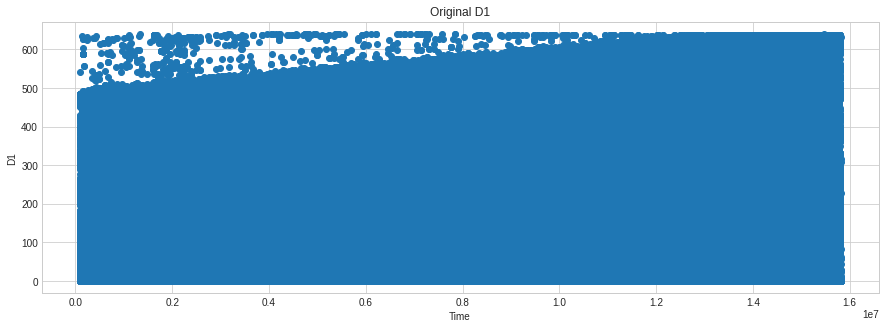

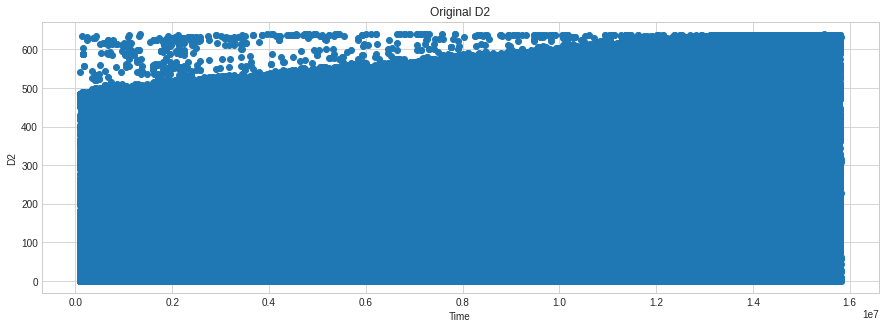

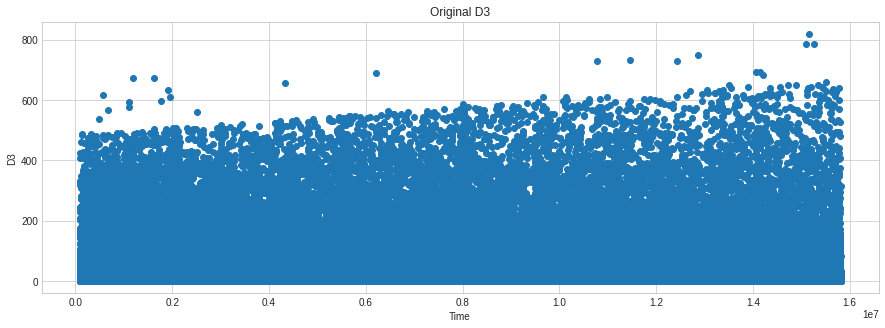

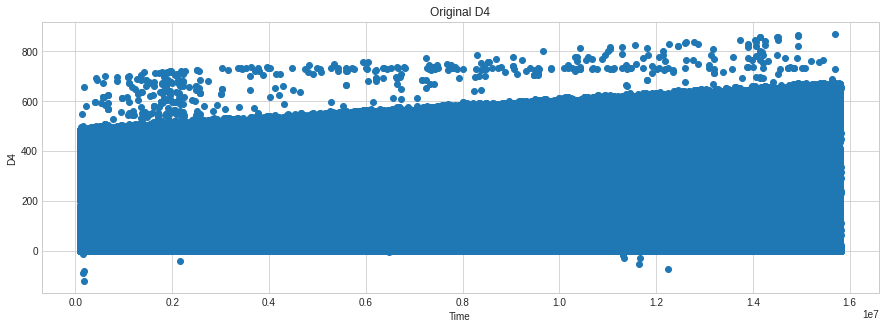

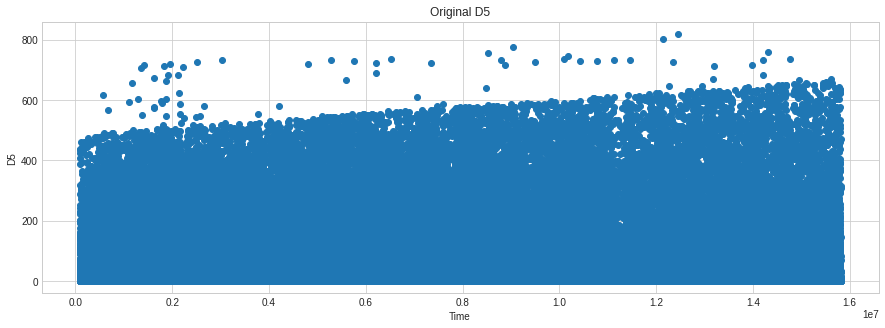

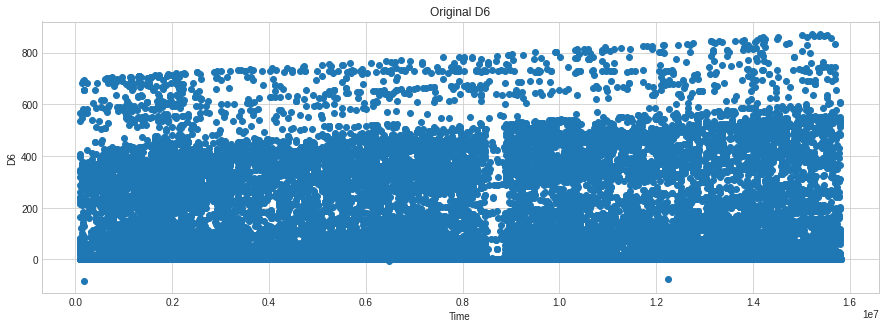

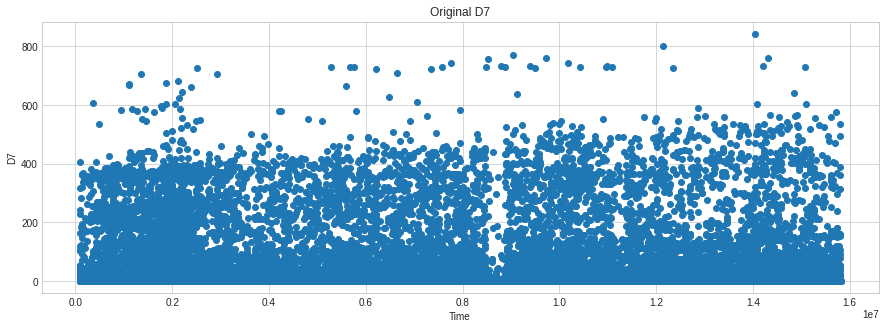

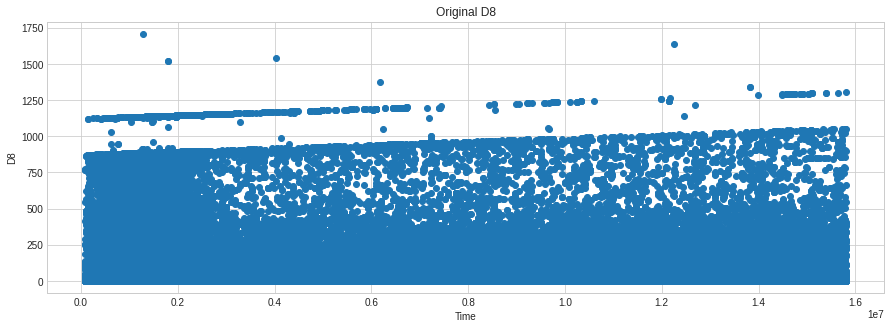

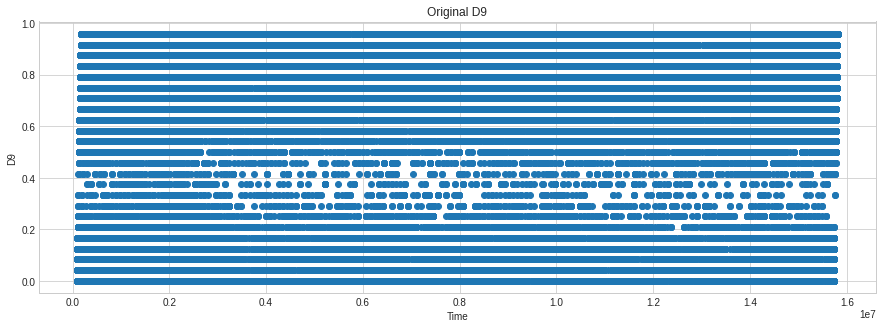

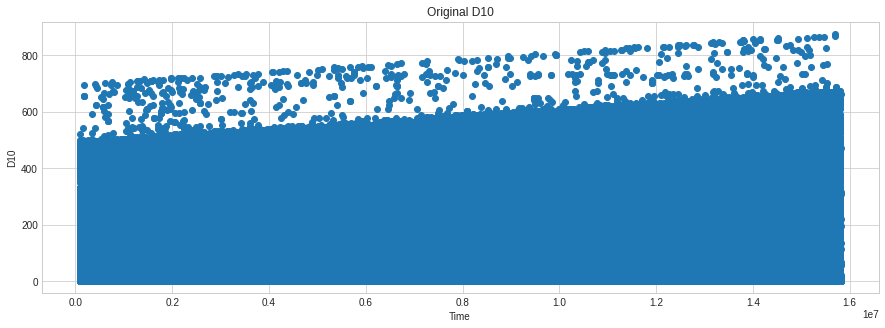

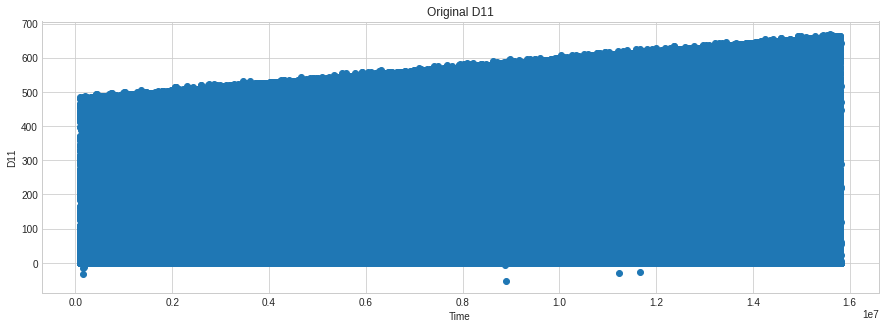

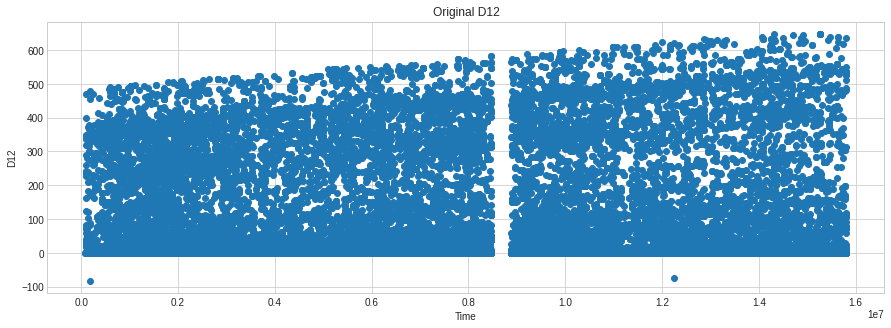

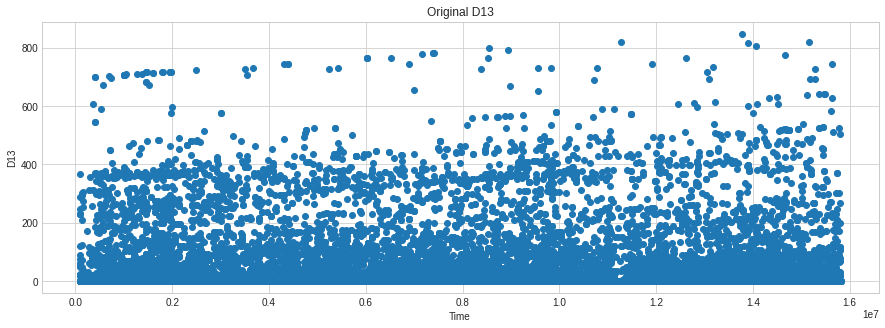

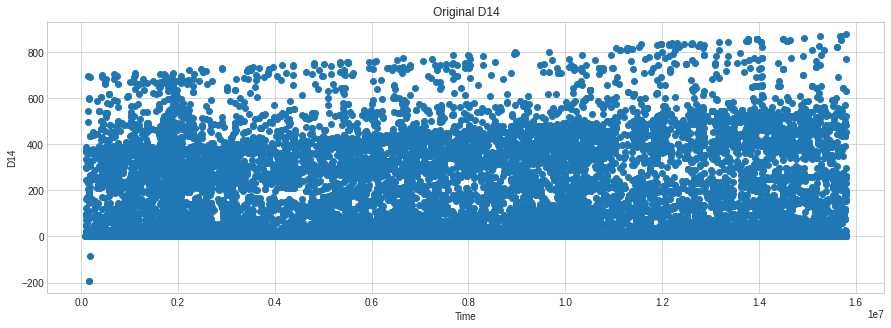

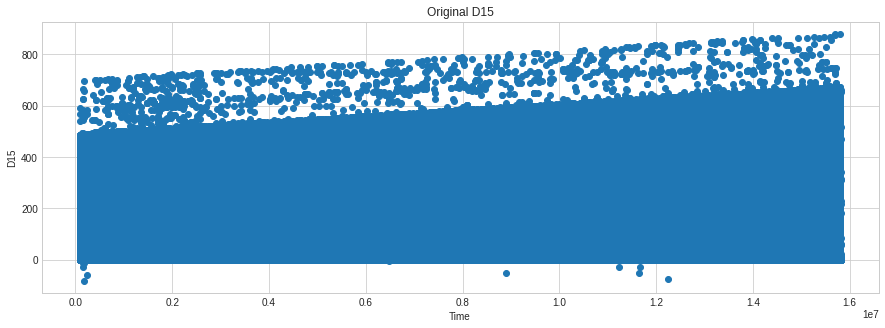

In [ ]:
for col in d_cols:
    # PLOT ORIGINAL D
    plt.figure(figsize=(15,5))
    plt.scatter(df_train['TransactionDT'],df_train[col])
    plt.title(f'Original {col}')
    plt.xlabel('Time')
    plt.ylabel(f'{col}')
    plt.show()

D1 is assumed to be days since the client credit card began.Subtracting this value from the “Transaction Day” will result in CONSTANT values per client

Let us see how it looks after normalizing

In [ ]:
df_train['D1n'] =  df_train['D1'] - df_train.TransactionDT/np.float32(24*60*60)

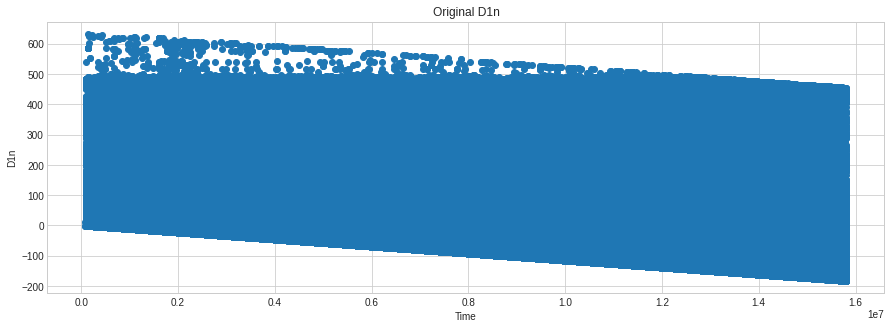

In [ ]:
d_cols = ['D1n']
for col in d_cols:
    # PLOT ORIGINAL D
    plt.figure(figsize=(15,5))
    plt.scatter(df_train['TransactionDT'],df_train[col])
    plt.title(f'Original {col}')
    plt.xlabel('Time')
    plt.ylabel(f'{col}')
    plt.show()

<Figure size 1440x1440 with 0 Axes>

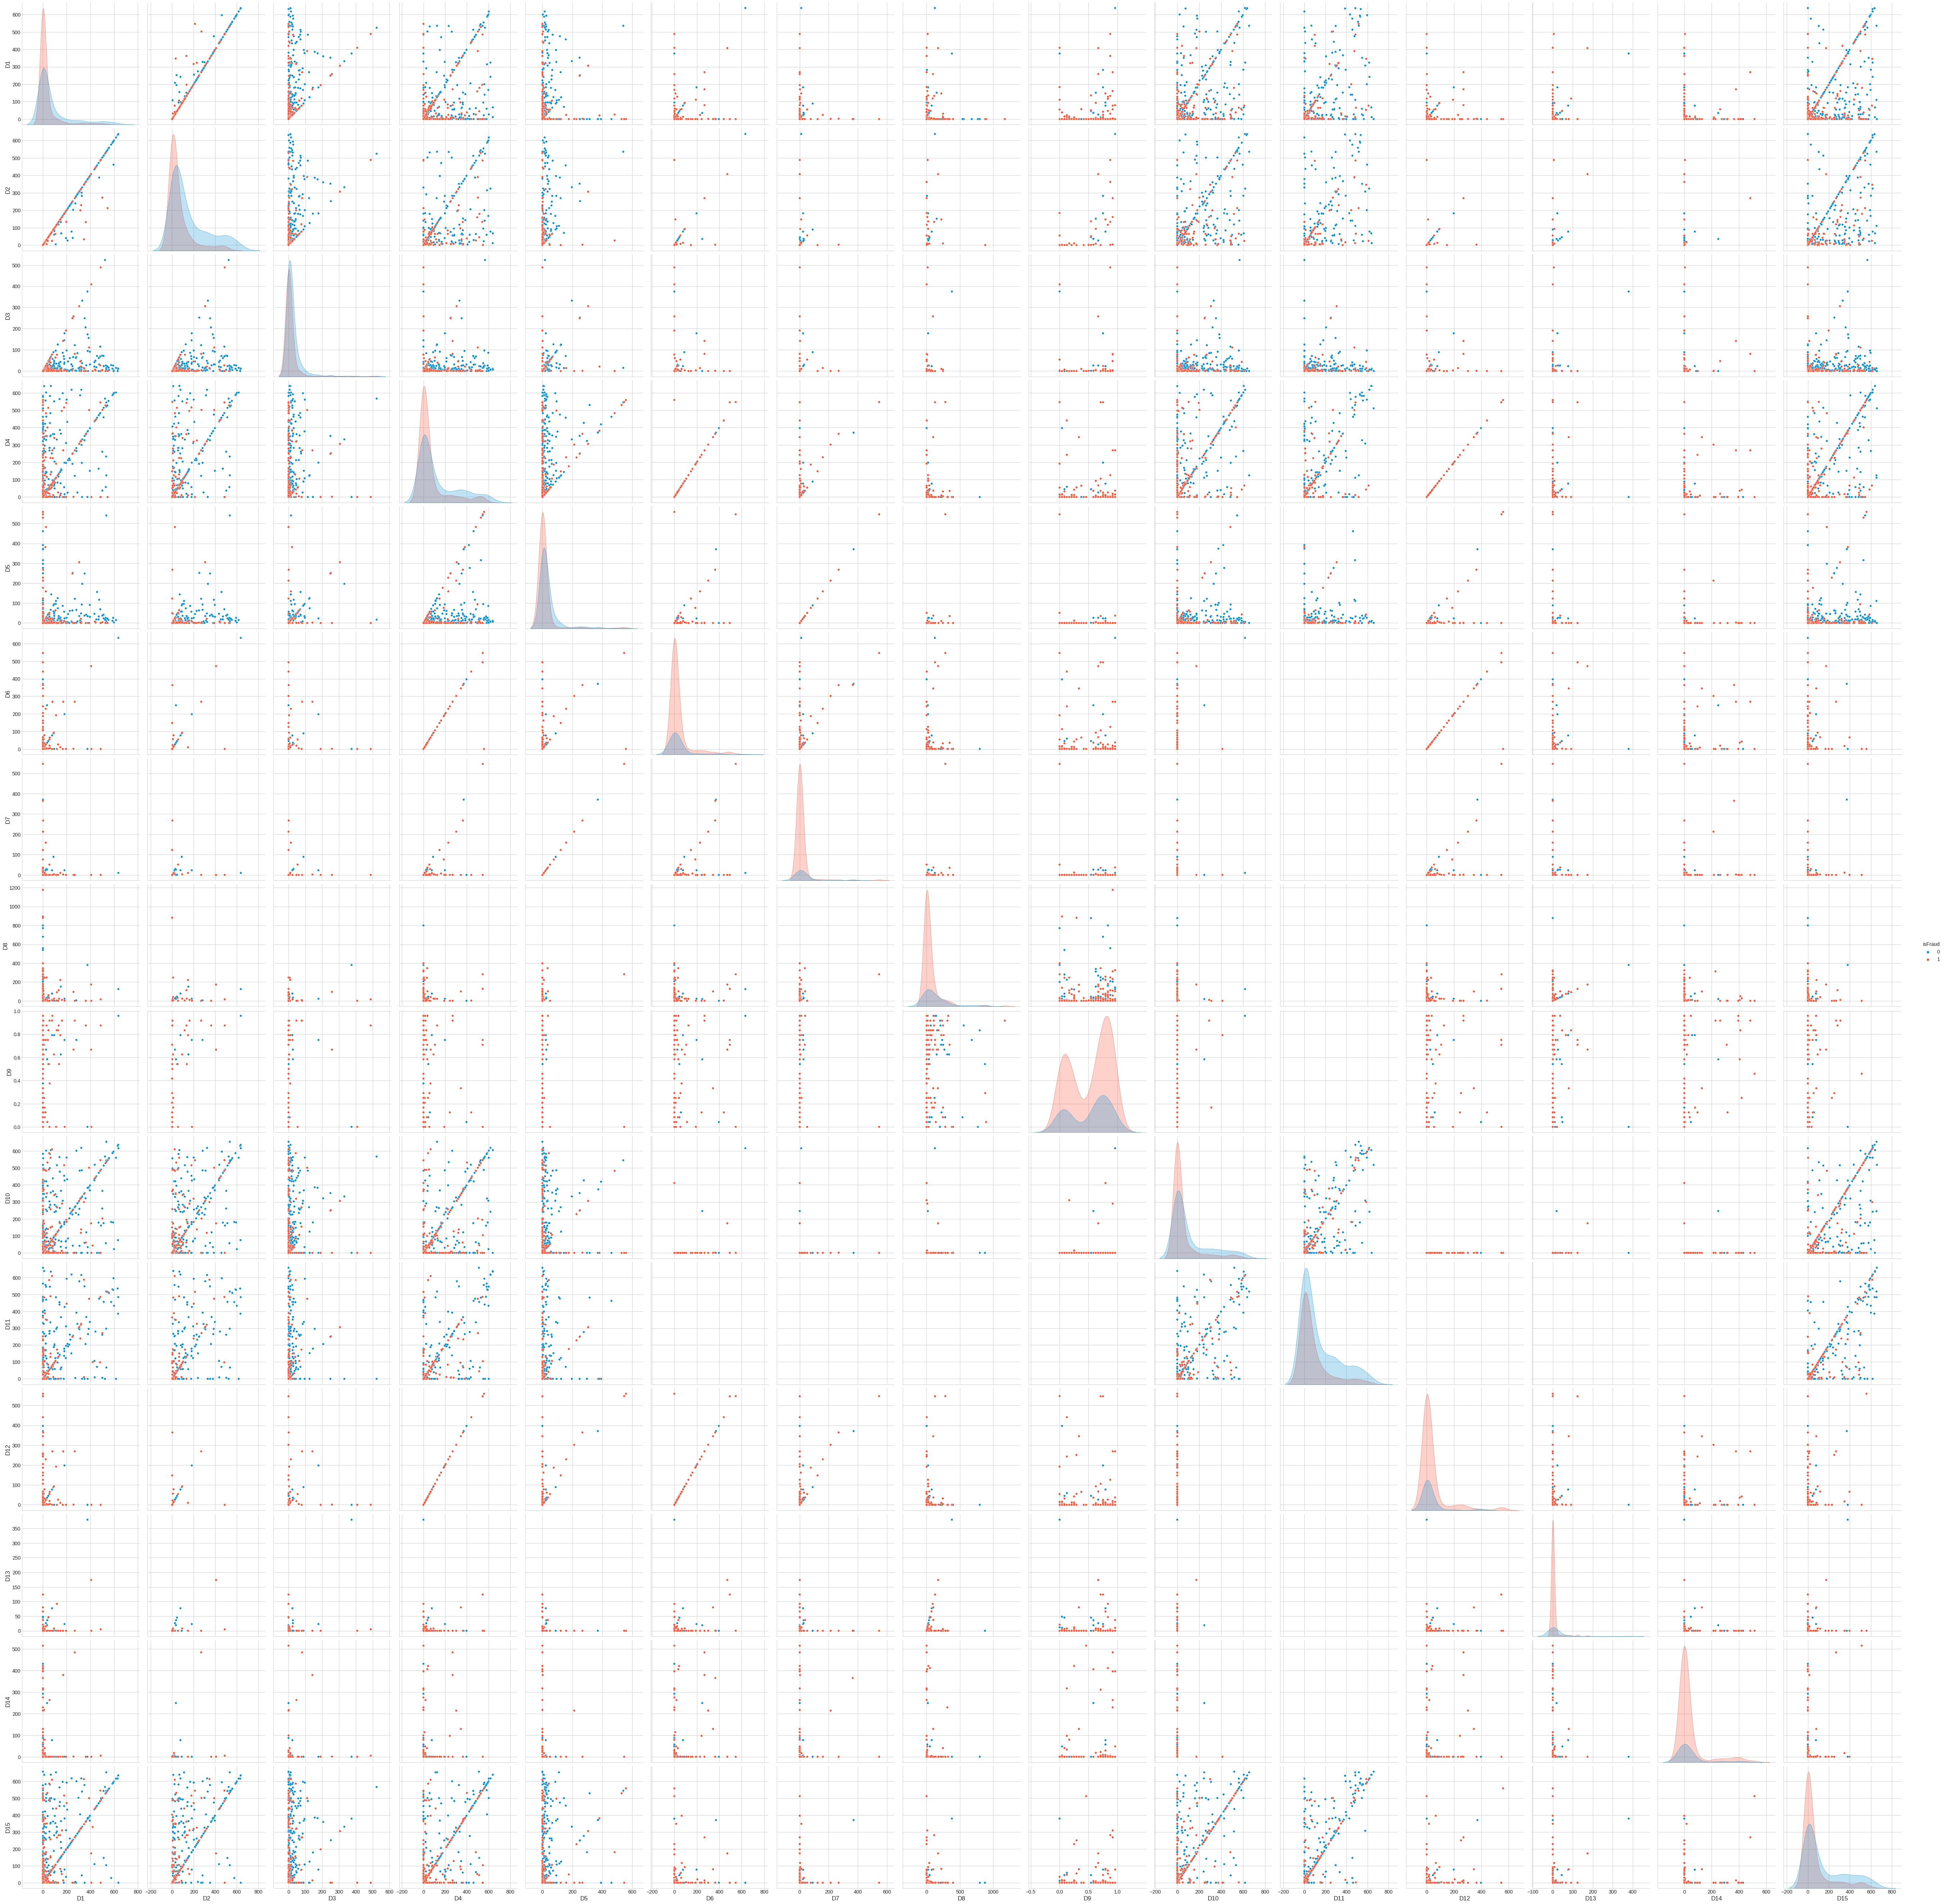

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(sample_df, 
             hue='isFraud',
            vars=d_cols,height=5)
plt.show()

* We can see that linearity as well as non linearity exist between features

## [2.10] M1-M9

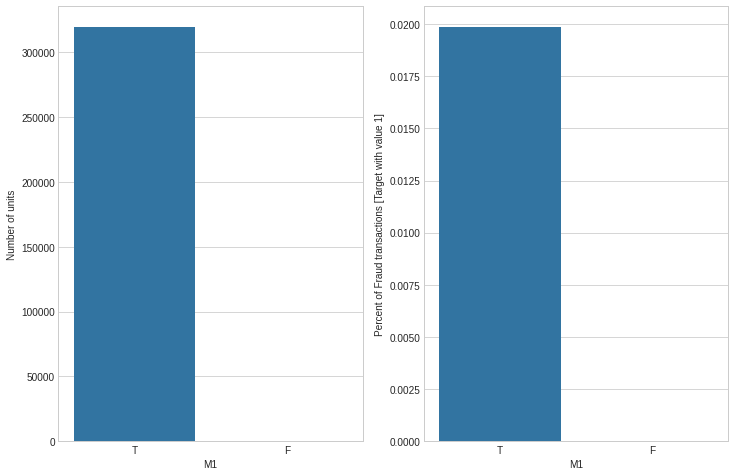

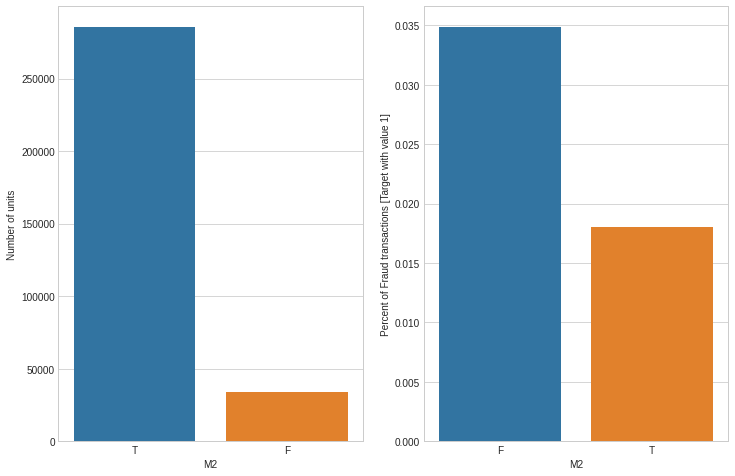

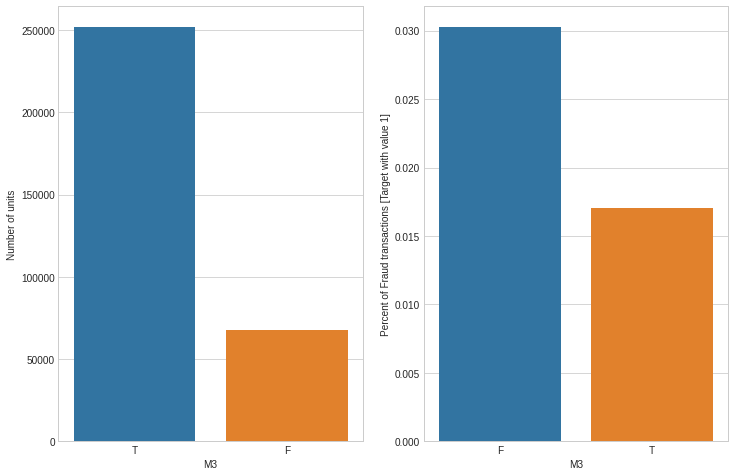

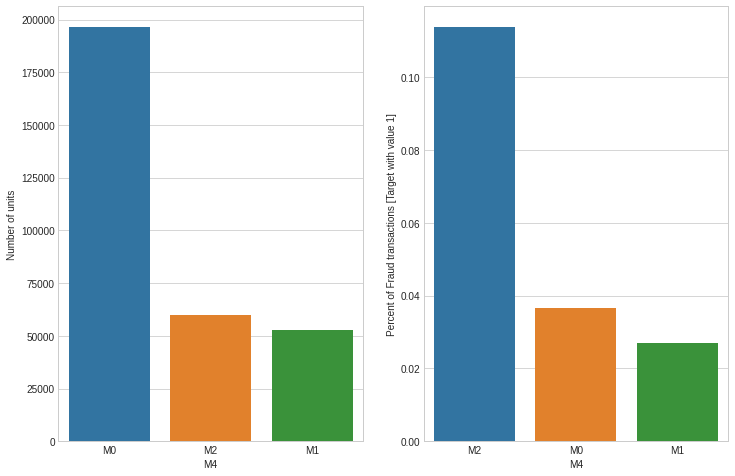

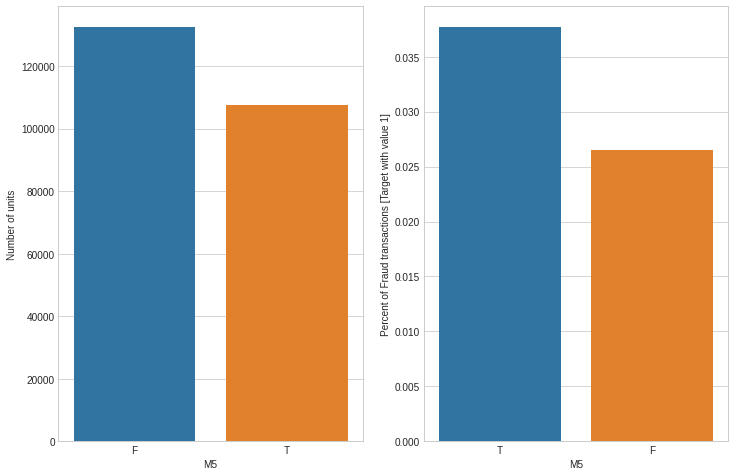

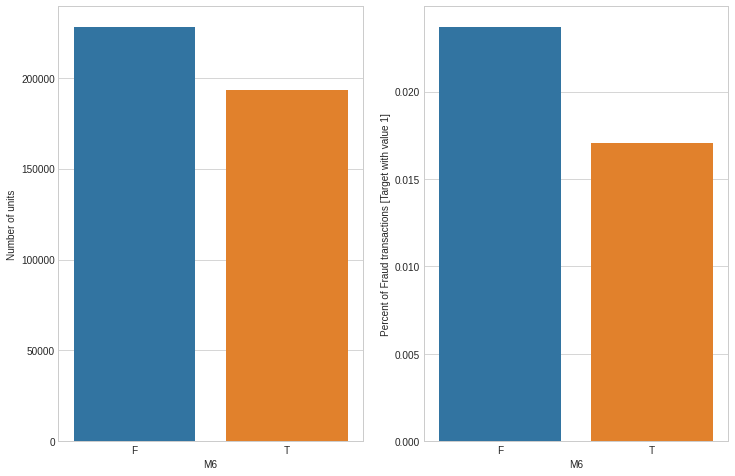

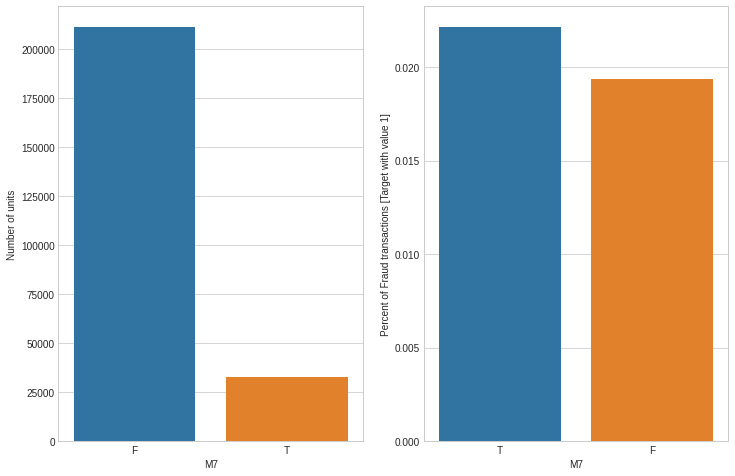

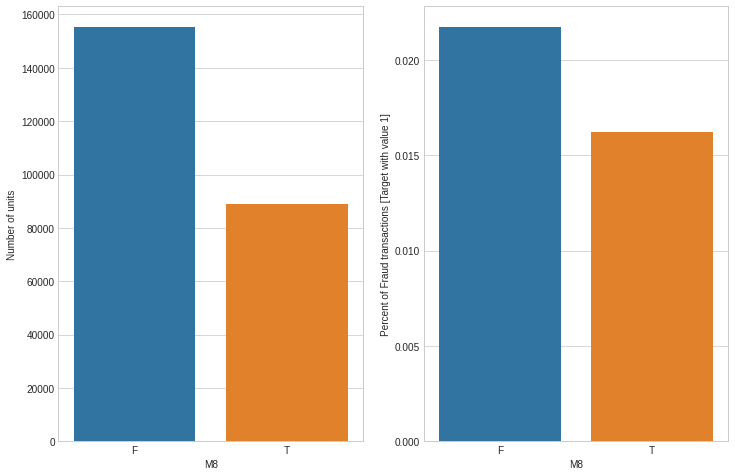

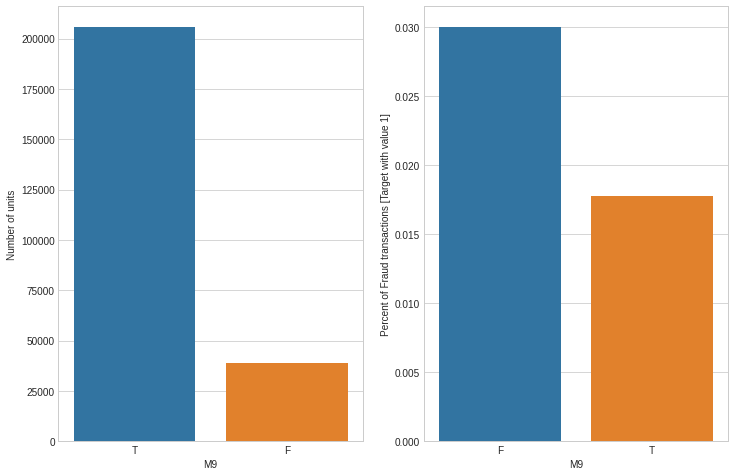

In [ ]:
m_cols = [m for m in df_train.columns if m[0] == 'M']

for col in m_cols:
    hor_plot(col)
    plt.show()

* In M1 of all cases of T, 2% are fraudulant
* In M2 of all cases of F, 3.5% are fraudulant
* similar readings can be obtained from above graph

## [2.11] V1 -V399

In [ ]:
v_cols = [c for c in df_train if c[0] == 'V']
df_train[v_cols].head()

V1   V2   V3   V4   V5   V6   V7  ...  V333  V334  V335  V336  V337  V338  V339
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 339 columns]

In [ ]:
df_train[v_cols].describe()

V1             V2  ...           V338           V339
count  311253.000000  311253.000000  ...   82351.000000   82351.000000
mean        0.999945       1.045204  ...     151.160542     100.700882
std         0.007390       0.240133  ...    1095.034387     814.946722
min         0.000000       0.000000  ...       0.000000       0.000000
25%         1.000000       1.000000  ...       0.000000       0.000000
50%         1.000000       1.000000  ...       0.000000       0.000000
75%         1.000000       1.000000  ...       0.000000       0.000000
max         1.000000       8.000000  ...  104060.000000  104060.000000

[8 rows x 339 columns]

## [2.12]Device type

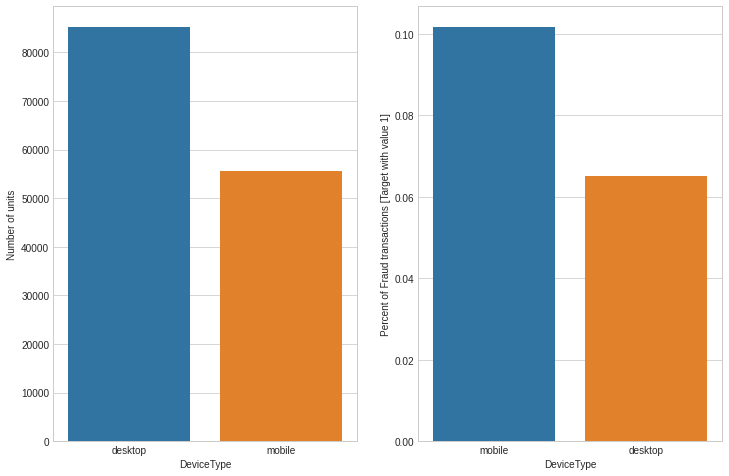

In [ ]:
hor_plot('DeviceType',df_train)

* We can see that fraud transaction are mostly made on mobile transactions which is roughly about 10% while only 6.2% fraud in desktop trasactions.

## [2.13] Device Info

Information about device used

In [ ]:
tmp = df_train[['DeviceInfo','isFraud']].groupby(by=['DeviceInfo']).mean().sort_values(by='isFraud',ascending=False)
print(tmp[tmp['isFraud'] > 0.9].shape)
tmp[tmp['isFraud'] > 0.9]

(49, 1)


isFraud
DeviceInfo                            
ZTE-Z835                      1.000000
Dream                         1.000000
SM-T285M                      1.000000
A5002                         1.000000
A466BG                        1.000000
SM-T530                       1.000000
Blade L3 Build/KOT49H         1.000000
RNE-L23 Build/HUAWEIRNE-L23   1.000000
SAMSUNG-SM-N900A              1.000000
MotoG3-TE Build/MPD24.65-33   1.000000
N9560 Build/NMF26F            1.000000
NOKIA                         1.000000
NX785QC8G                     1.000000
Nexus 6 Build/MOB30M          1.000000
XT1033                        1.000000
G3123 Build/40.0.A.6.175      1.000000
ZTE-Z956                      1.000000
TAB7                          1.000000
rv:14.0                       1.000000
rv:29.0                       1.000000
RCT6203W46 Build/KOT49H       1.000000
SM-A300M Build/KTU84P         1.000000
VS5012 Build/NRD90M           1.000000
Hisense E51 Build/LMY47V      1.000000
SM-T217S Build/KOT49H         1.000000
Beat                          1.000000
Alumini3 Build/MRA58K         1.000000
LGLK430                       1.000000
SM-G955F                      1.000000
SM-G928F                      1.000000
SM-G925T Build/LMY47X         1.000000
ZEIA8                         1.000000
Z965 Build/NMF26V             1.000000
iPhone                        1.000000
Z835 Build/NMF26V             1.000000
Z813 Build/LMY47O             1.000000
SM-G615F                      1.000000
SM-J700T Build/MMB29K         1.000000
LG-D693n Build/KOT49I.V10a    1.000000
SM-N920A Build/MMB29K         1.000000
XT890 Build/9.8.2I-50_SML-25  1.000000
XT1609                        1.000000
Mi                            1.000000
SM-G850M                      1.000000
A574BL Build/NMF26F           1.000000
XT1021                        1.000000
hi6210sft Build/MRA58K        0.947368
Lenovo YT3-850M Build/MMB29M  0.909091
TR10CS1 Build/JDQ39           0.909091

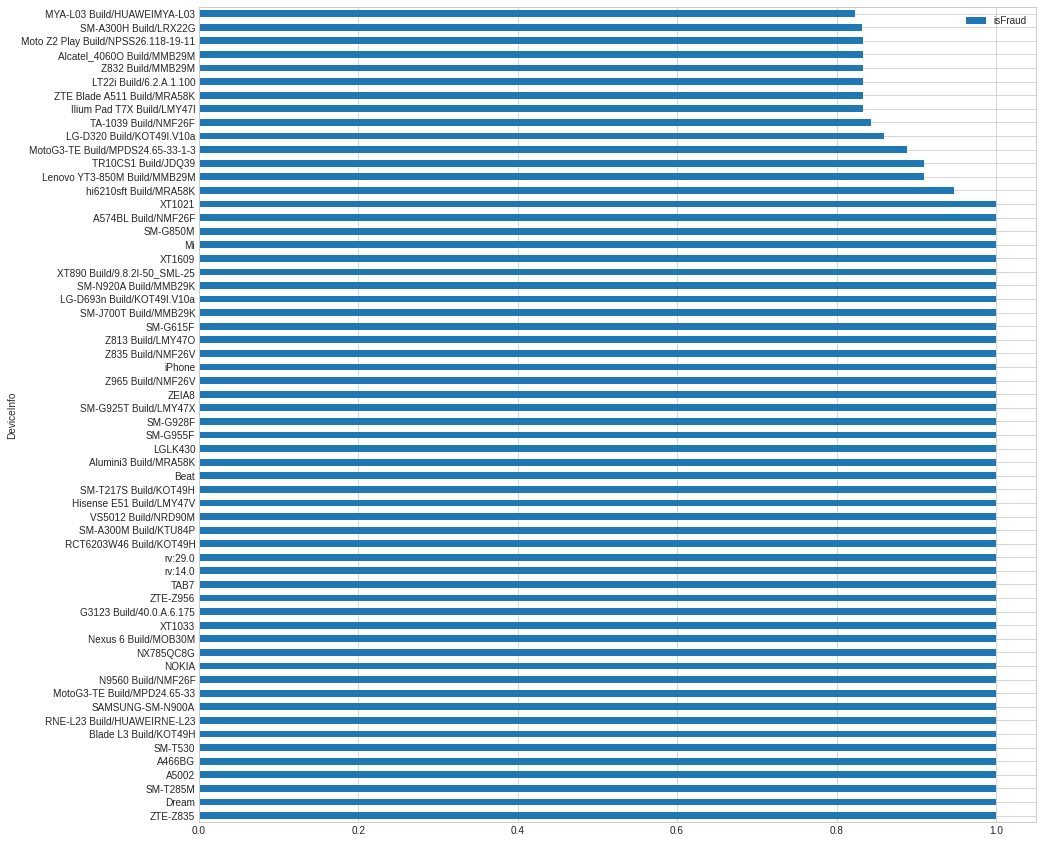

In [ ]:
tmp.head(60).plot(kind='barh',figsize=(15, 15))
plt.show()

* We can see that about 49 device information we have chances of being fraud transaction > 90%

## [2.14] Id 12 - 38

These are categorical data. It contains network connection information,browser information etc

In [ ]:
catid_cols = ['id_'+str(i) for i in range(12,39)]
df_train[catid_cols].head()

id_12  id_13  id_14 id_15  ... id_35  id_36  id_37  id_38
0       NaN    NaN    NaN   NaN  ...   NaN    NaN    NaN    NaN
1       NaN    NaN    NaN   NaN  ...   NaN    NaN    NaN    NaN
2       NaN    NaN    NaN   NaN  ...   NaN    NaN    NaN    NaN
3       NaN    NaN    NaN   NaN  ...   NaN    NaN    NaN    NaN
4  NotFound    NaN -480.0   New  ...     T      F      T      T

[5 rows x 27 columns]

* We will see top fraud cases in each category.

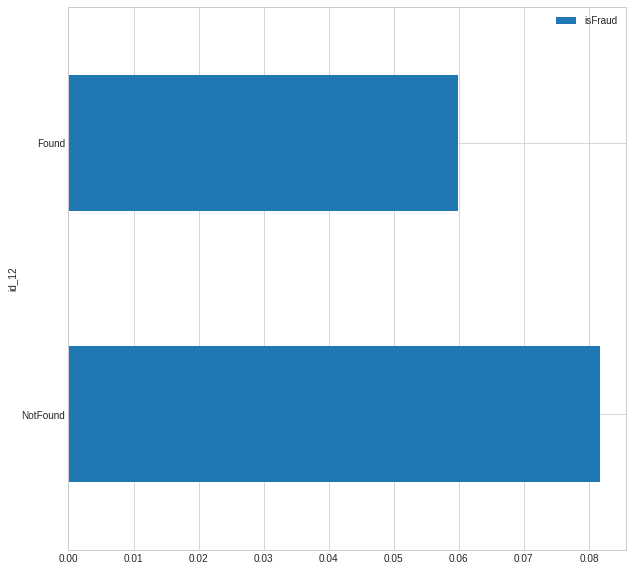

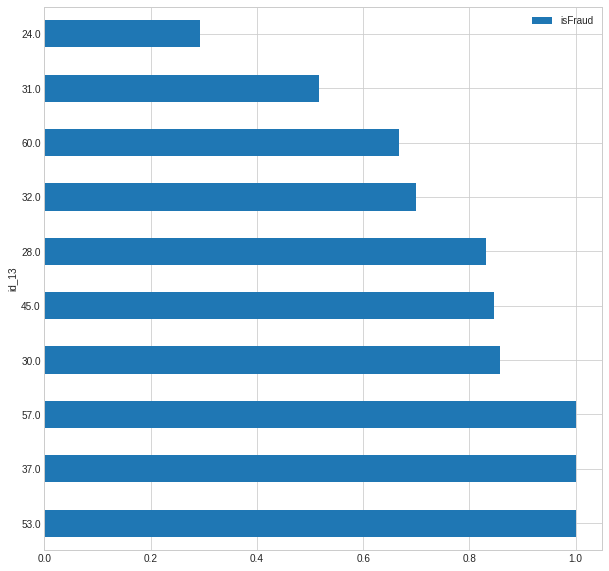

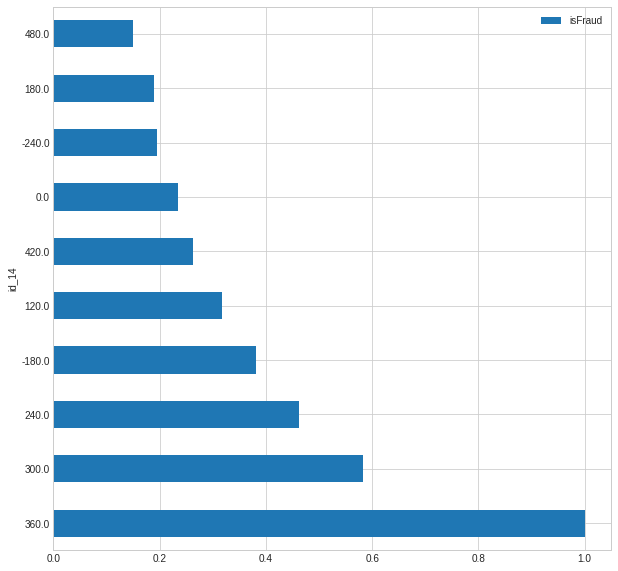

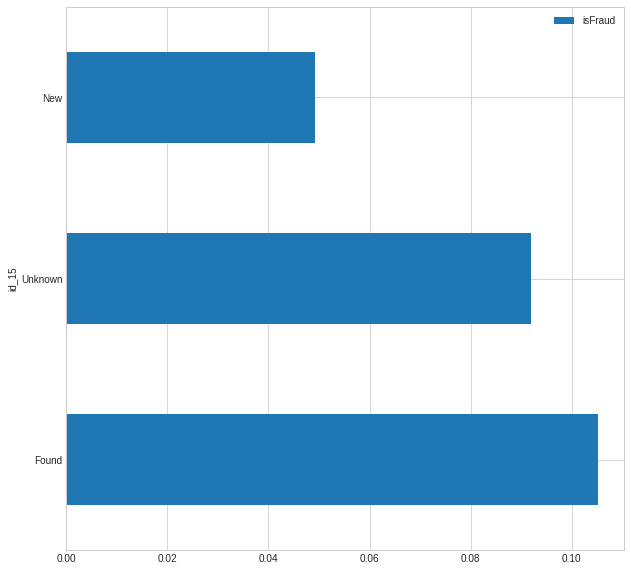

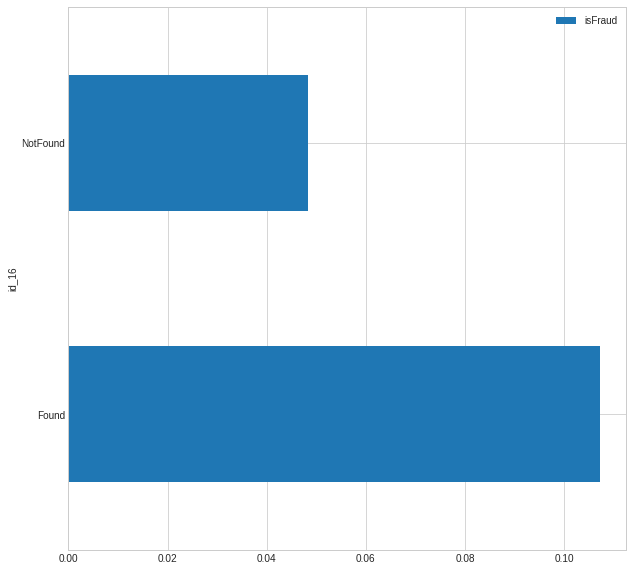

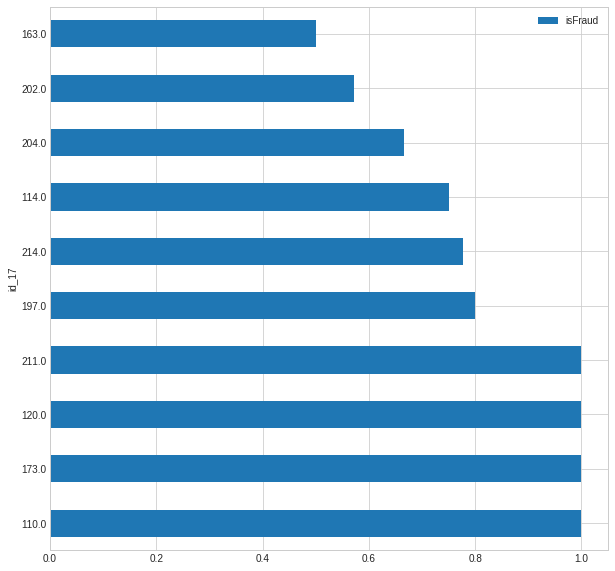

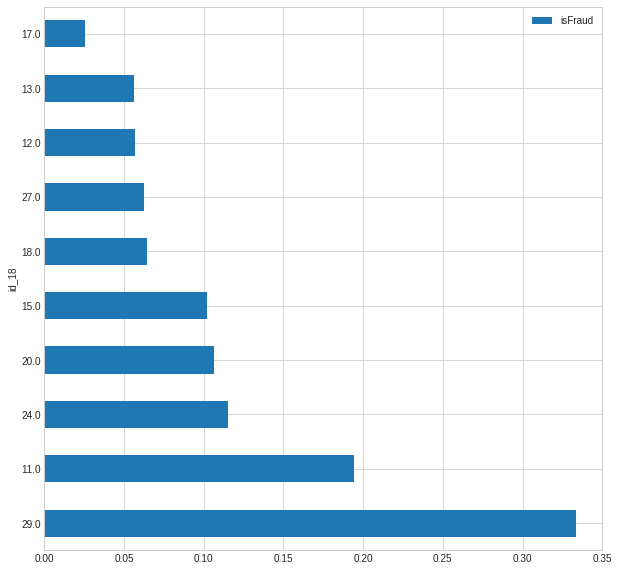

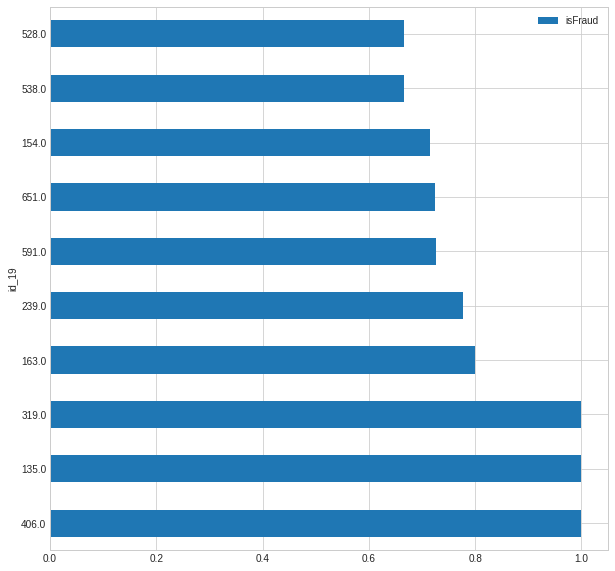

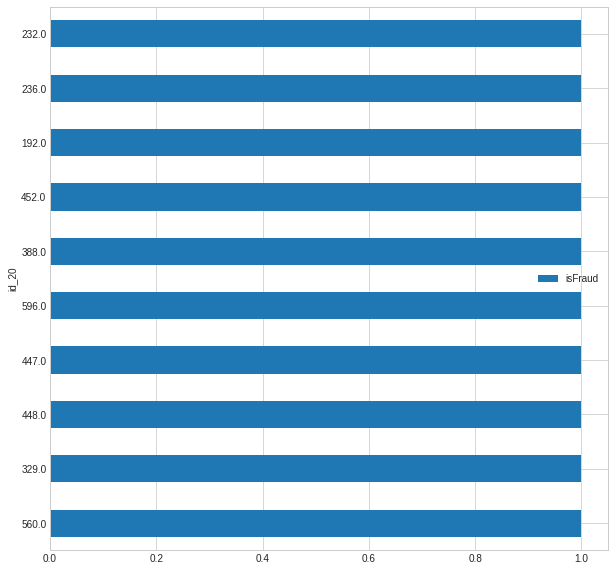

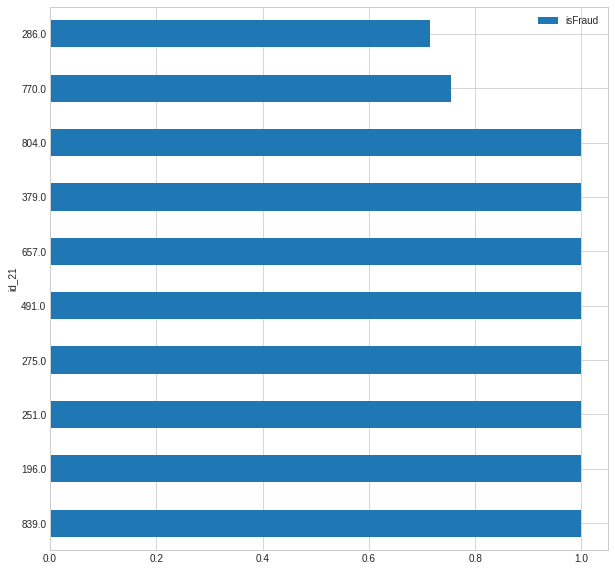

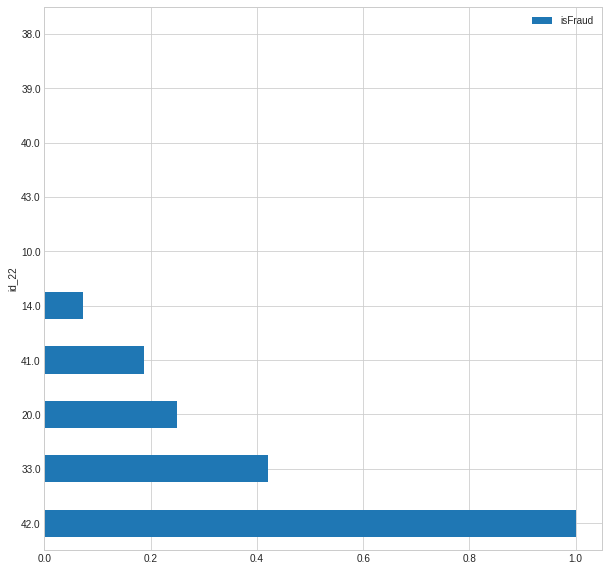

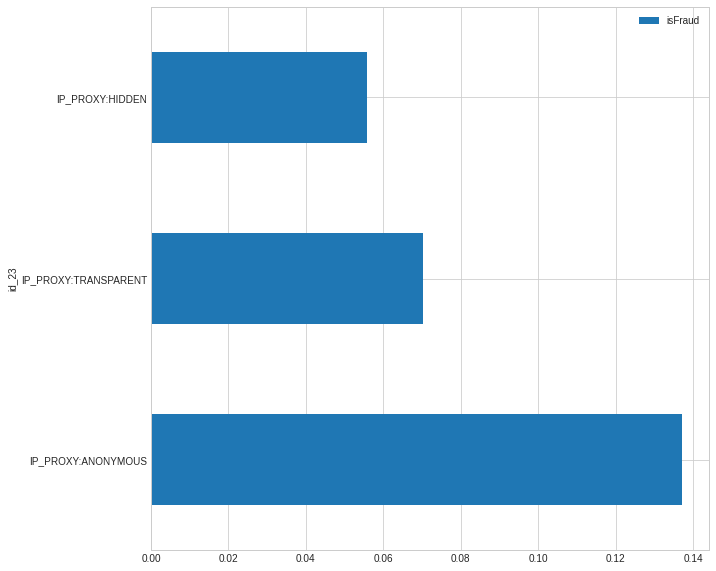

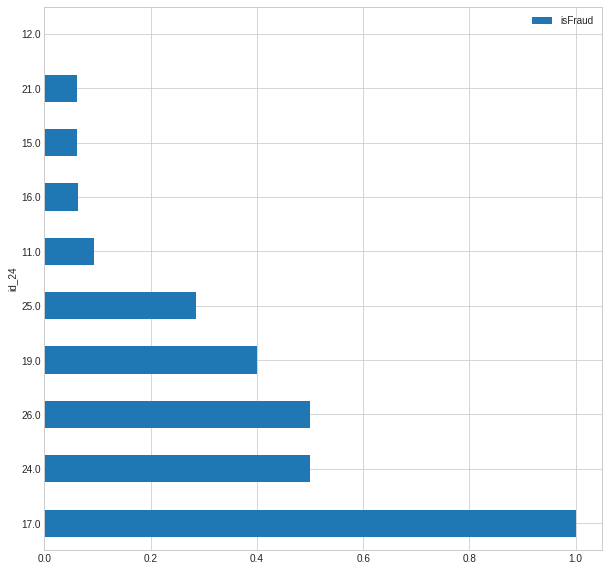

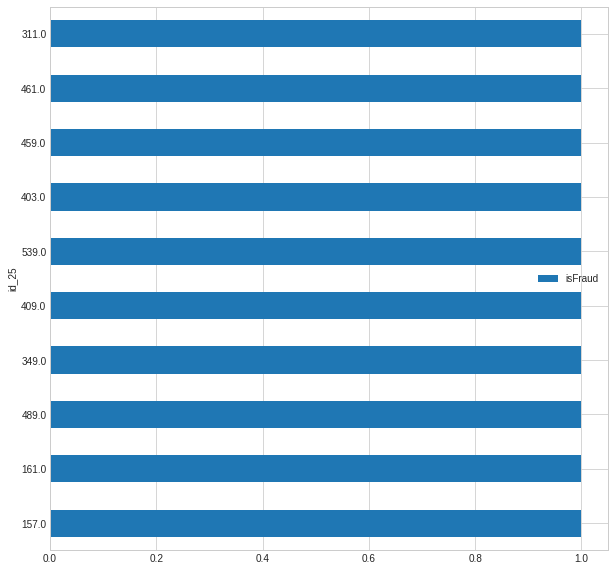

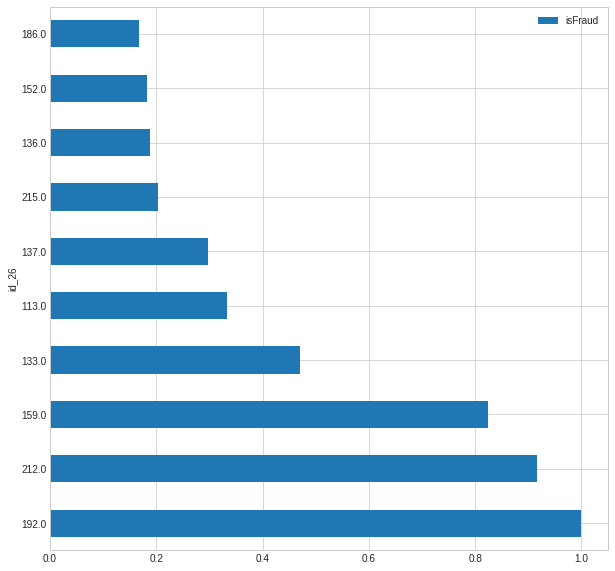

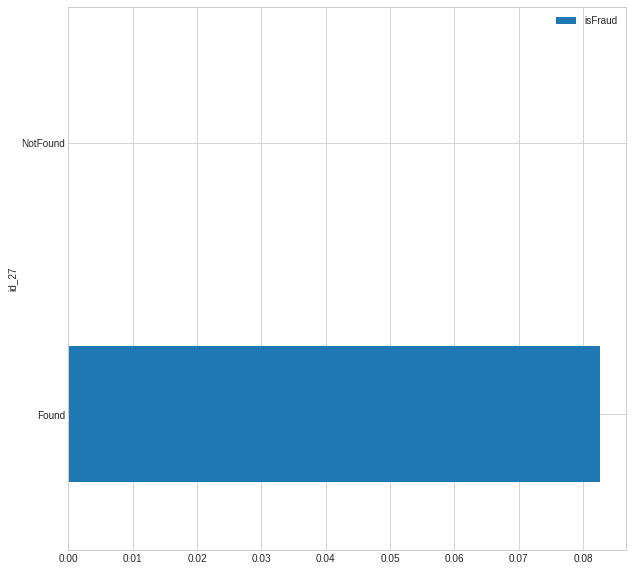

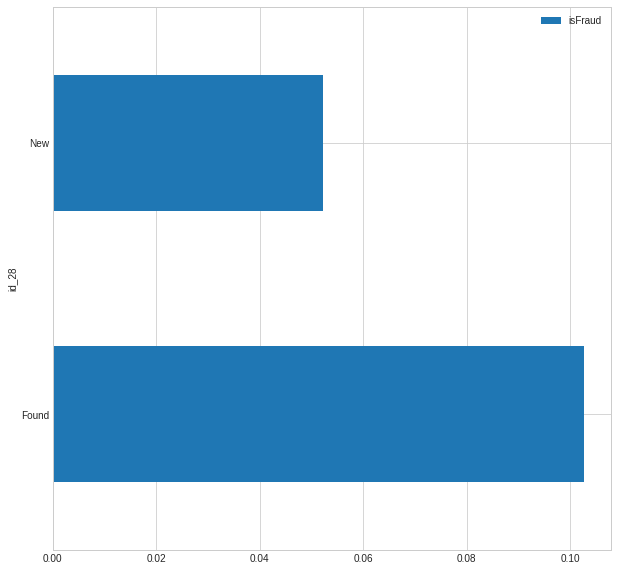

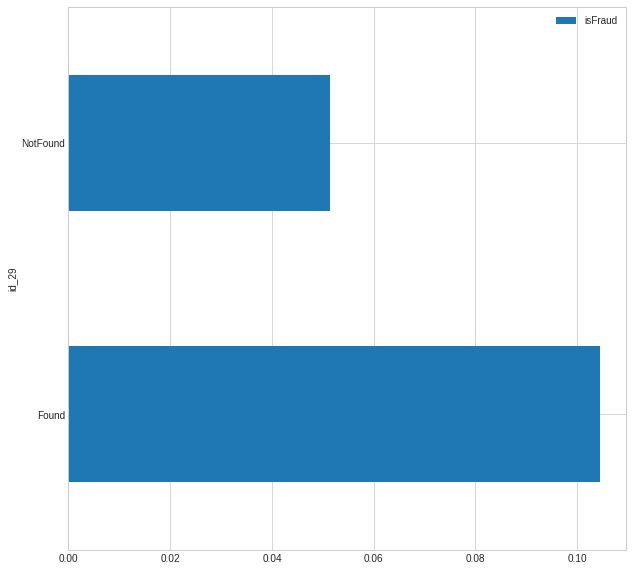

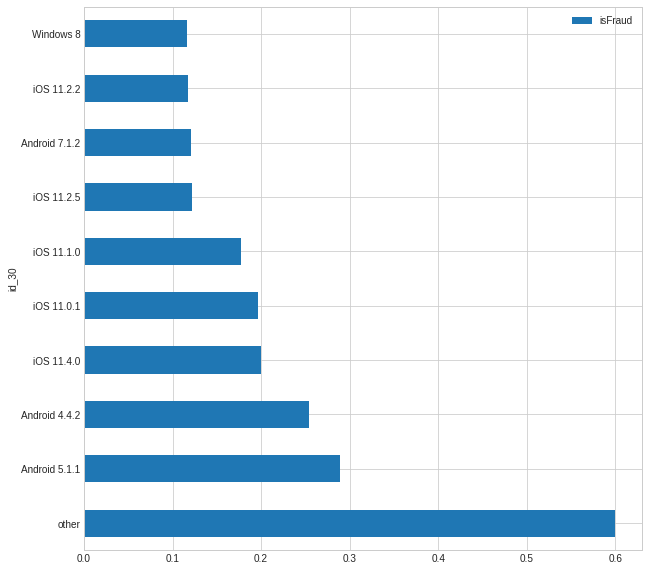

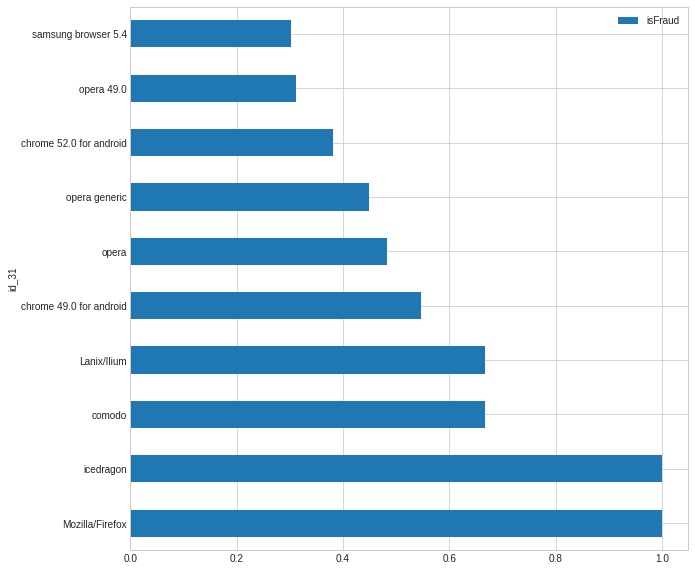

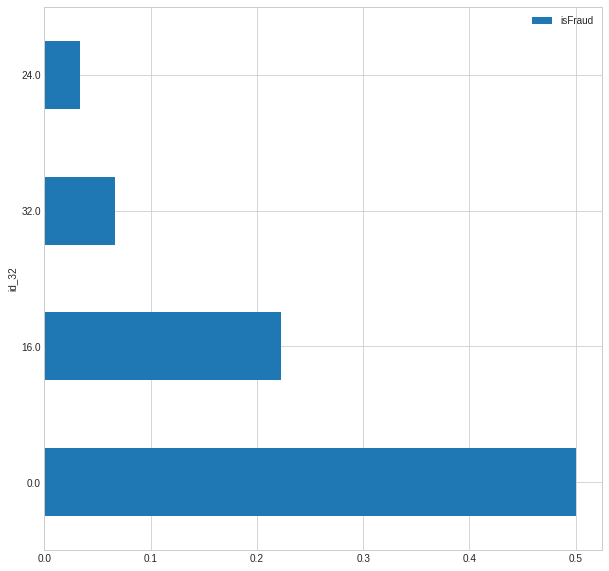

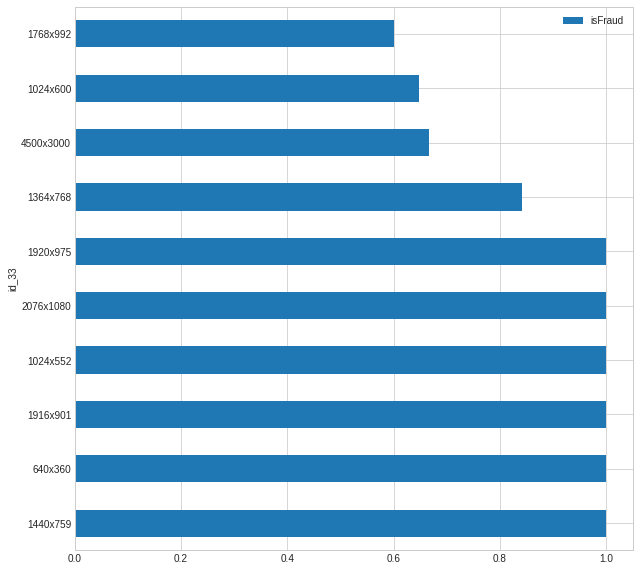

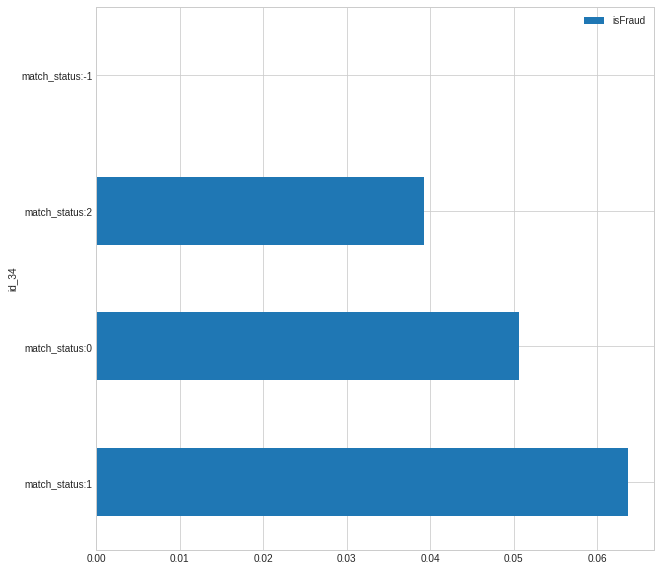

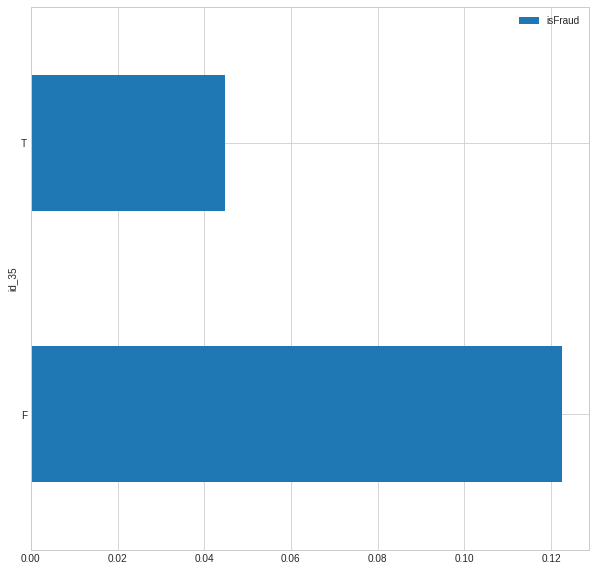

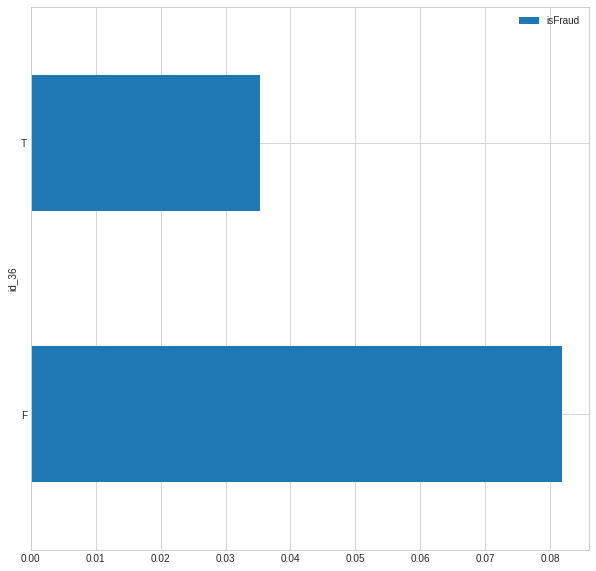

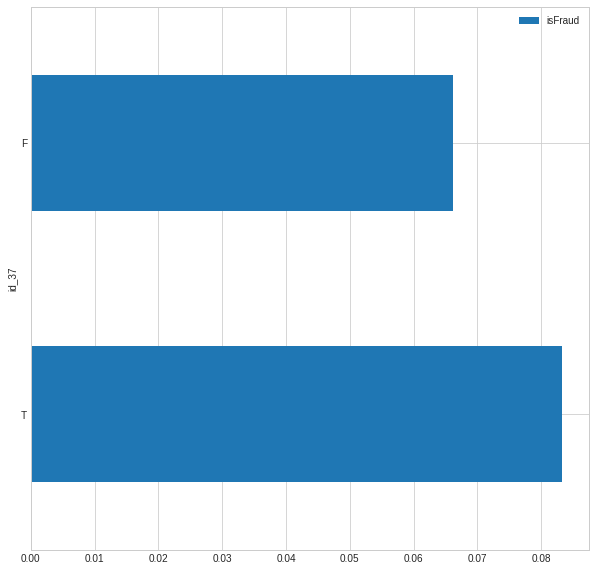

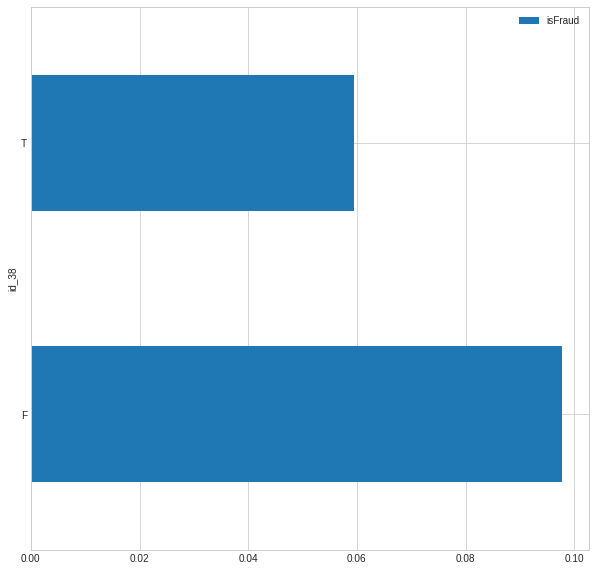

In [ ]:
for col in catid_cols:
    df_train[[col,'isFraud']].groupby(by=[col]).mean().sort_values(by=['isFraud'],ascending=False).head(10).\
            plot(kind='barh',figsize=(10, 10))
    plt.show()

## [3] BaseLine Model

In [ ]:
# df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')
# df_train.to_csv('data/train_combined.csv',index=False)
# df_train.head()
# gc.collect()

In [ ]:
# df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')
# df_test.to_csv('data/test_combined.csv',index=False)
# gc.collect()
# df_test.head()

In [ ]:
# # missing_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] > 0.8]
# req_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] < 0.7]
# df_train = df_train[req_cols]
# req_cols.remove('isFraud')
# df_test = df_test[req_cols]
# print(df_train.shape)
# print(df_test.shape)

## Logistic regression

In [ ]:

X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']
X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 431)
(506691, 431)


183

In [ ]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X_train = clean_inf_nan(X_train)
X_test = clean_inf_nan(X_test)

print(X_train.shape)
print(X_test.shape)

(590540, 431)
(506691, 431)


In [ ]:
del df_train,df_test

In [ ]:

from sklearn.model_selection import train_test_split
X_train_,X_cv_,y_train_,y_cv_ = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

print(X_train_.shape)
print(X_cv_.shape)
print(y_train_.shape)
print(y_cv_.shape)

(413378, 431)
(177162, 431)
(413378,)
(177162,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(exclude=object).columns.tolist()


# 1. Median imputation for numarical features
# 2. Standardizing


# Featurization of numeric data
imputer = SimpleImputer(strategy='median')
x_train_n = imputer.fit_transform(X_train_[num_cols])
x_cv_n = imputer.transform(X_cv_[num_cols])
x_test_n = imputer.transform(X_test[num_cols])

scaler = StandardScaler()
x_train_nums = scaler.fit_transform(x_train_n)
x_cv_nums = scaler.transform(x_cv_n)
x_test_nums = scaler.transform(x_test_n)


x_train_num_final = pd.DataFrame(x_train_nums, columns=num_cols)
x_cv_num_final = pd.DataFrame(x_cv_nums, columns=num_cols)
x_test_num_final = pd.DataFrame(x_test_nums, columns=num_cols)

gc.collect()

print(x_train_num_final.shape)
print(x_cv_num_final.shape)
print(x_test_num_final.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# we are manually giving datatype because some categorical columns are labelled as float/int
cat_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

for col in cat_cols:
    if col in X_train.columns:
        X_train_[col] = X_train_[col].astype('object')
        X_cv_[col] = X_cv_[col].astype('object')
        X_test[col] = X_test[col].astype('object')
        
        
        X_train_[col]= X_train_[col].fillna('MISSING')
        X_cv_[col]= X_cv_[col].fillna('MISSING')
        X_test[col] = X_test[col].fillna('MISSING')
        
        lb = LabelEncoder()
        lb.fit(list(X_train_[col].values) + list(X_test[col].values) + list(X_cv_[col].values))
        X_train_[col] = lb.transform(list(X_train_[col].values))
        X_cv_[col] = lb.transform(list(X_cv_[col].values)) 
        X_test[col] = lb.transform(list(X_test[col].values))
    

In [ ]:
# Final complete data
x_train_num_final = x_train_num_final.reset_index(drop=True)
x_cv_num_final = x_cv_num_final.reset_index(drop=True)
x_test_num_final = x_test_num_final.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_cv = X_cv.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

x_train = pd.concat([x_train_num_final,X_train_[object_cols]], axis = 1)
x_cv = pd.concat([x_cv_num_final,X_cv_[object_cols]], axis = 1)
x_test = pd.concat([x_test_num_final,X_test[object_cols]], axis = 1)

print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(413378, 223)
(177162, 223)
(506691, 223)


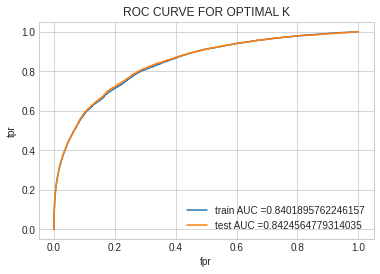

Area under train roc 0.8401895762246157
Area under test roc 0.8424564779314035


In [ ]:


best_est = LogisticRegression(solver='liblinear',class_weight='balanced')
best_est = best_est.fit(x_train,y_train)
y_pred = best_est.predict(x_cv)

train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, best_est.predict_proba(x_cv)[:,1])
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_cv,y_pred)

array([[130249,  40714],
       [  1482,   4717]])

In [ ]:
y_pred_test = best_est.predict_proba(x_test)[:,1]
submission = pd.read_csv('data/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('submission.csv',index=False)
submission.head()

TransactionID   isFraud
0        3663549  0.135383
1        3663550  0.377544
2        3663551  0.451534
3        3663552  0.118240
4        3663553  0.117974

![image-2.png](attachment:image-2.png)

Score: 0.8666

## RandomForest

In [ ]:
df_train = pd.read_csv('data/train_combined.csv')
df_test = pd.read_csv('data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


In [6]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]


In [7]:
## Train and test split¶
y_train_ = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()


(590540, 433)
(506691, 433)


64

In [8]:
del df_train,df_test

In [9]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [10]:
# Scaling numeric features
cols = X_train.columns
for col in cols:
    if col not in cat_cols and col not in id_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff


In [11]:
# # train test split
# from sklearn.model_selection import train_test_split
# x_train,x_cv_,y_train,y_cv = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

idx_train = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

x_train,y_train = X_train.iloc[idx_train],y_train_.iloc[idx_train]
x_cv_,y_cv = X_train.iloc[idx_validation],y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 433)
(147635, 433)
(442905,)
(147635,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))



Area under train roc 1.0
Area under test roc 0.8800832509662229


**Hyper parameter tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = RandomizedSearchCV(estimator=clf,  param_distributions=parameters, cv=3, n_iter=6, scoring='roc_auc')
model.fit(x_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [ ]:
model.best_params_

{'max_depth': 15, 'n_estimators': 10}

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=15,n_estimators=10)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))



Area under train roc 0.9030092390642274
Area under test roc 0.8600826621875466


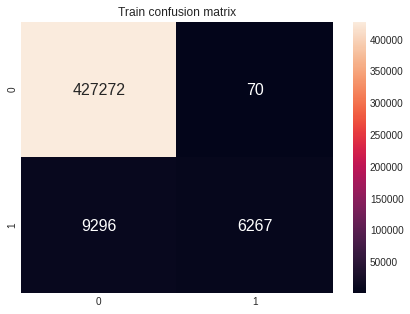

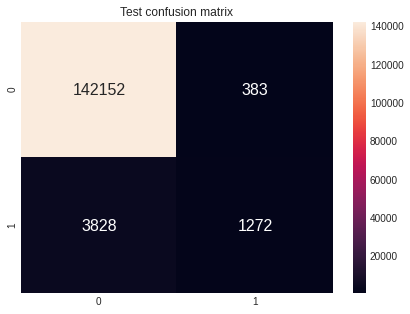

In [13]:
train_cf = confusion_matrix(y_train,y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_cv,y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

## Xgboost

In [ ]:
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[1000,2000],'max_depth':[3,6,12],'subsample':[0.4,0.8]}



clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4)



model = RandomizedSearchCV(estimator=clf, param_distributions=params, scoring='roc_auc', verbose=1, cv=3, n_iter=6)
model.fit(x_train,y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 25.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.4,
                                           eval_metric='auc', gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=-1, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                    

In [ ]:
model.best_params_

{'max_depth': 12, 'n_estimators': 2000, 'subsample': 0.8}

In [14]:
model = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,subsample=0.8)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9999040418691912
Area under test roc 0.915318807145407


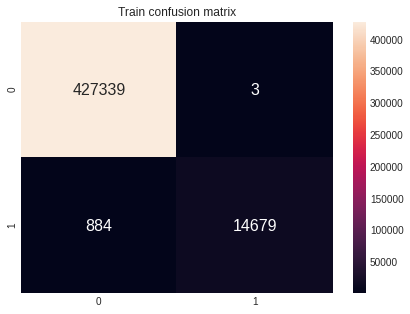

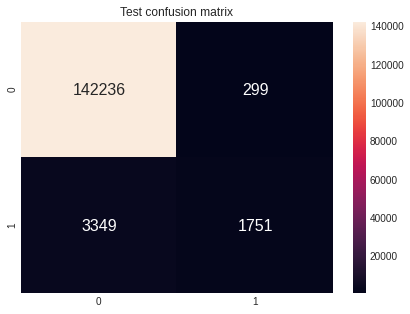

In [16]:


train_cf = confusion_matrix(y_train,y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_cv,y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

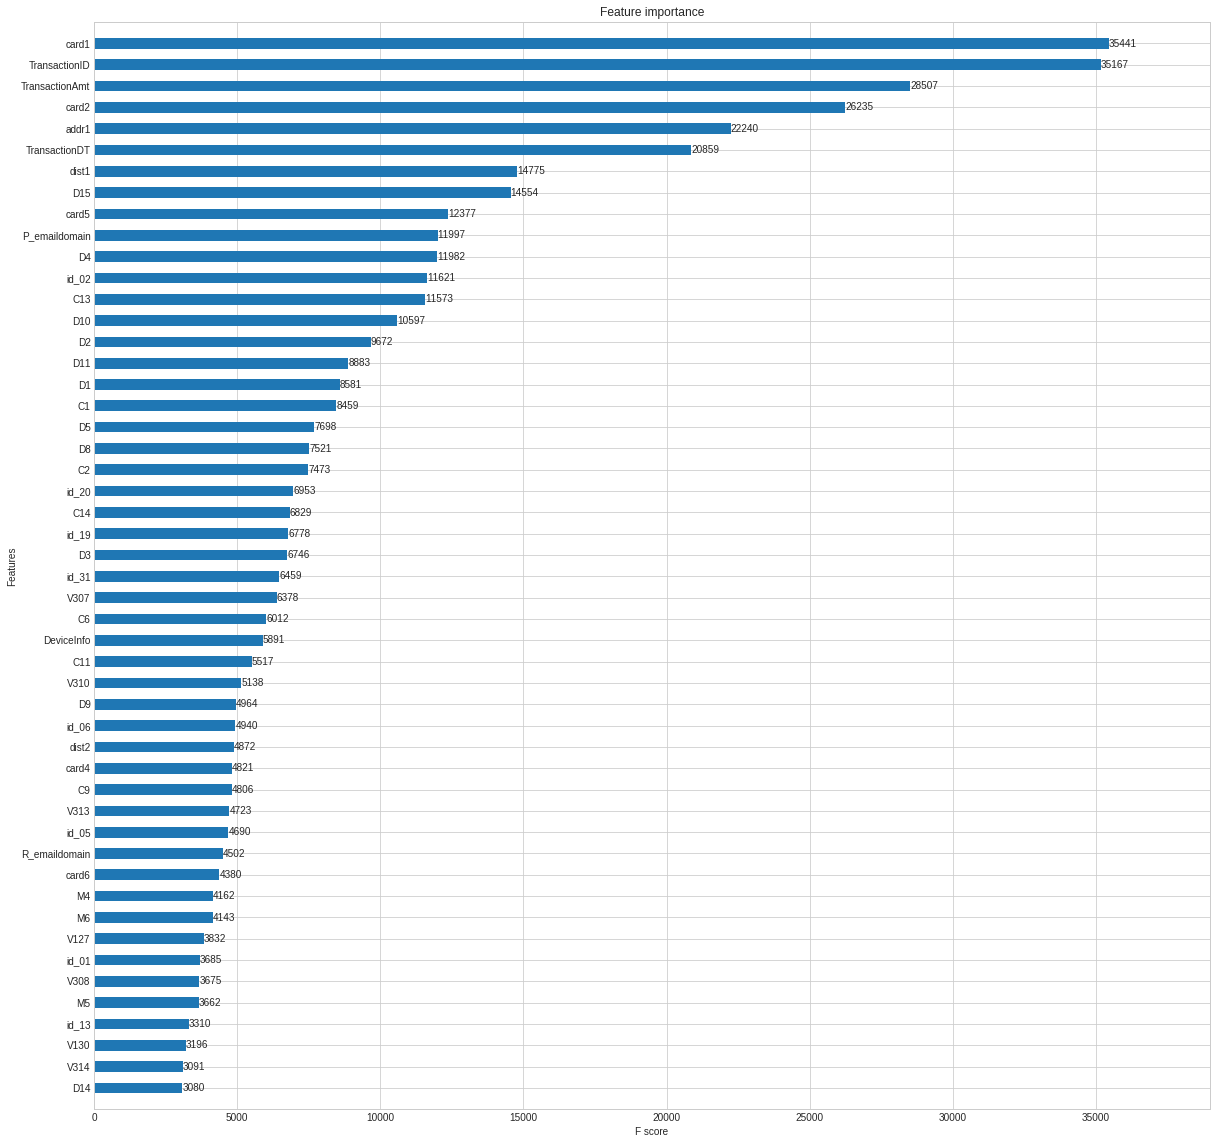

In [17]:
# Area under train roc 0.9562337894195517
# Area under test roc 0.9373441236609897

from xgboost import plot_importance
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
plot_importance(model,max_num_features=50,height=0.5,ax=axes)
plt.show()

## Let us do a early stoping to avoid overfit and check the perfomance

In [18]:
clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,
        subsample=0.8)


model = clf.fit(x_train, y_train, 
    eval_set=[(x_cv_,y_cv)],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.811575
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.865837
[100]	validation_0-auc:0.878909
[150]	validation_0-auc:0.888131
[200]	validation_0-auc:0.89883
[250]	validation_0-auc:0.907656
[300]	validation_0-auc:0.914403
[350]	validation_0-auc:0.918454
[400]	validation_0-auc:0.921064
[450]	validation_0-auc:0.921798
[500]	validation_0-auc:0.922355
[550]	validation_0-auc:0.922811
[600]	validation_0-auc:0.923278
[650]	validation_0-auc:0.922892
[700]	validation_0-auc:0.922651
Stopping. Best iteration:
[604]	validation_0-auc:0.923433



In [21]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9948942038764454
Area under test roc 0.9234332331171498


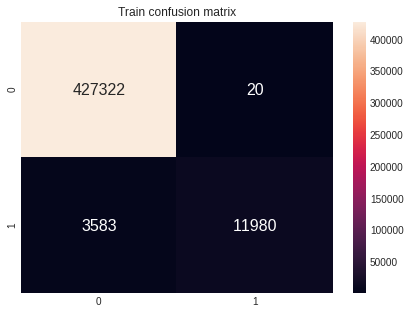

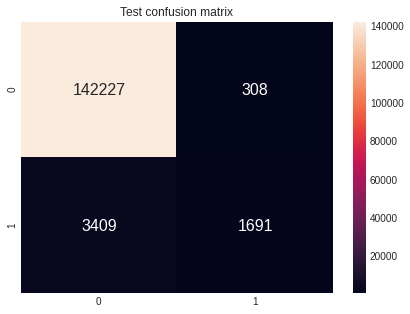

In [20]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_cf = confusion_matrix(y_train,y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_cv,y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

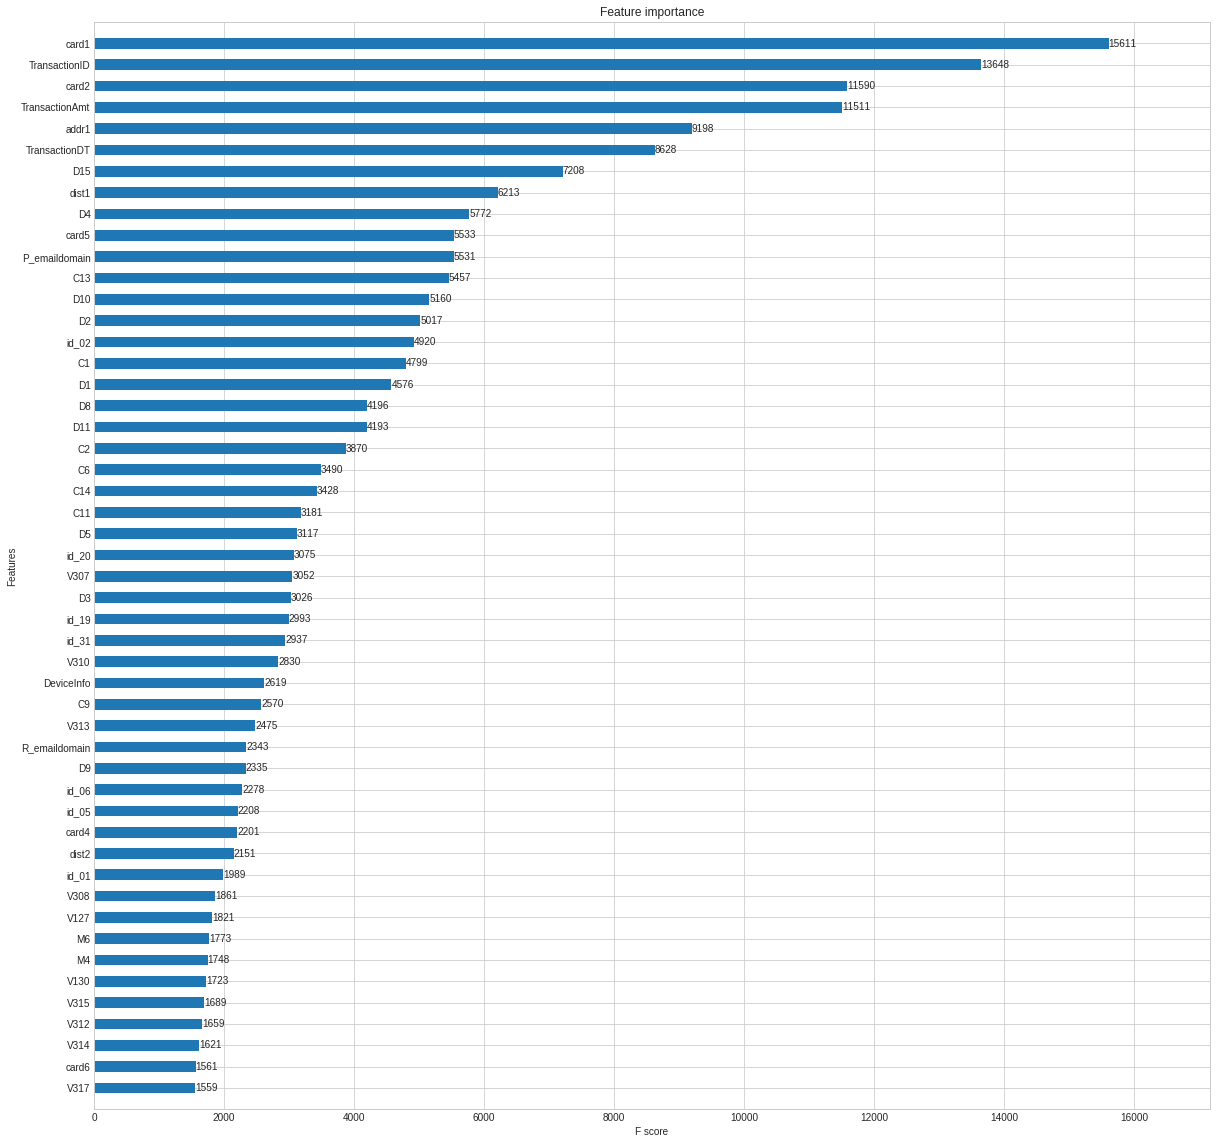

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
plot_importance(model,max_num_features=50,height=0.5,ax=axes)
plt.show()

In [ ]:
del model

In [23]:
y_pred_test = model.predict_proba(X_test)[:,1]
submission = pd.read_csv('data/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('submission.csv',index=False)
submission.head()

TransactionID   isFraud
0        3663549  0.004483
1        3663550  0.004349
2        3663551  0.004451
3        3663552  0.001906
4        3663553  0.003371

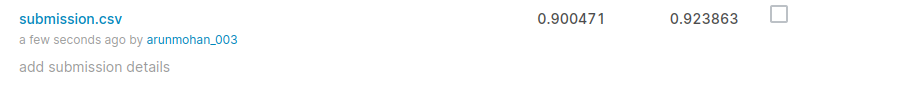





Public LB : 0.9238<br>
Private LB: 0.900471

In [ ]:


# gc.collect()
# param_grid = {
#     'max_depth': [3,6,12],
#     'learning_rate': [0.02,0.002,0.2],
#     'subsample': [0.4,0.8],
#     'colsample_bytree': [0.4, 0.6],
#     'reg_lambda': [0.1, 1.0, 5.0],
#     'n_estimators': [1000,2000,5000]
# }
# clf = xgb.XGBClassifier()

# rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=6,
#                             n_jobs=-1, verbose=2, cv=3,
#                             scoring='roc_auc', refit=False, random_state=42)

# print("Randomized search..")
# search_time_start = time.time()
# rs_clf.fit(x_train, y_train)
# print("Randomized search time:", time.time() - search_time_start)

# best_score = rs_clf.best_score_
# best_params = rs_clf.best_params_
# print(best_score)
# print(best_params)